# Exploratory data analysis of moth data across all ECN sites

This notebook is the first of several notebooks where we explore the moth dataset (`/data/ecn/ECN_IM1.csv`) in detail. This notebook primarly focuses on
1. Determining which sites may be suitable for future analysis
1. How multiple measurements available at some sites may affect future analysis
1. Determining suitable transformations of the data to be used in future analysis
 - From `resources/IM.pdf` the moths are **trapped** in a Rothamstead light trap which requires emptying regularly
 - Therefore, a transformation of the moth counts may be necessary if the frequency of site visits changes

Notebooks such as `b-EDA-MOTHGROUP-STABLESTATION` will look further into the behaviour of the data; in this case, how the abundance of moth groups changes over time. 

Resources are available in `resources/`.

- Check that nothing else needs removing/dealing with (Michael T/Sue?)
- In particular MAKE SURE THE ZERO COUNTS ARE PRESENT WHEN CALCULATING INTERVAL

## load necessary `R` packages

In [1]:
## R script of useful functions for the moth/environment analysis
library(tidyverse)
library(feather)
library(dplyr)
library(lubridate)
library(ggplot2)
library(gridExtra)
library(readxl)
library(reticulate)
library(tibble)

setwd("/data/notebooks/jupyterlab-workshop/")

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.0 ──

✔ ggplot2 3.3.2     ✔ purrr   0.3.4
✔ tibble  3.0.4     ✔ dplyr   1.0.2
✔ tidyr   1.1.2     ✔ stringr 1.4.0
✔ readr   1.3.1     ✔ forcats 0.5.0

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()


Attaching package: ‘lubridate’


The following objects are masked from ‘package:base’:

    date, intersect, setdiff, union



Attaching package: ‘gridExtra’


The following object is masked from ‘package:dplyr’:

    combine




## Define site names

In [2]:
sites <- setNames(
    c(1:10,12),
    c(paste0("T0", 1:9), paste0("T", c(10,12)))
)
print(sites)

input <- list(
    site = names(sites),# 11 ECN sites
    daterange= c("1950-01-01","2021-01-01") # date range
)

T01 T02 T03 T04 T05 T06 T07 T08 T09 T10 T12 
  1   2   3   4   5   6   7   8   9  10  12 


## Load the data and manipulate as necessary

In [3]:
# some of this code is taken from Michael T's fucntions

# moth data
mothdata <- tibble::as_tibble(read.csv("/data/ecn/ECN_IM1.csv"))
  
# process
dd = mothdata %>%
    # change year format yy to yyyy
    dplyr::mutate(YEAR=as.integer(str_sub(SDATE, start= -2))) %>%
    dplyr::mutate(YEAR=if_else( YEAR <= 50,YEAR+2000,YEAR+1900)) %>%
    dplyr::mutate(DATE= as.Date(SDATE, format= "%d-%b-%y")) %>%
    # drop YEAR and SDATE columns
    dplyr::select(-YEAR,-SDATE) %>%
    # filter by (selected) sites
    dplyr::filter(SITECODE %in% input$site) %>%
    # get dates in specified date range
    dplyr::filter(
        as.Date(DATE) >= as.Date(input$daterange[1]) &
        as.Date(DATE) <= as.Date(input$daterange[2]) 
    ) %>%
    # remove rows with "Q" in FIELDNAME
    dplyr::filter(!str_detect(FIELDNAME, "Q"))
head(dd)

SITECODE LCODE FIELDNAME VALUE DATE      
1 T06      2     2542      1     1992-02-24
2 T06      2     929       1     1992-02-24
3 T06      2     2542      1     1992-02-25
4 T06      2     929       1     1992-02-25
5 T06      2     907       1     1992-03-05
6 T06      2     571       1     1992-03-09

## PLOT DATE Vs LCODE
- LCODE: is "ID for location (unique within site)"
- Multiple sites have multiple LCODE values

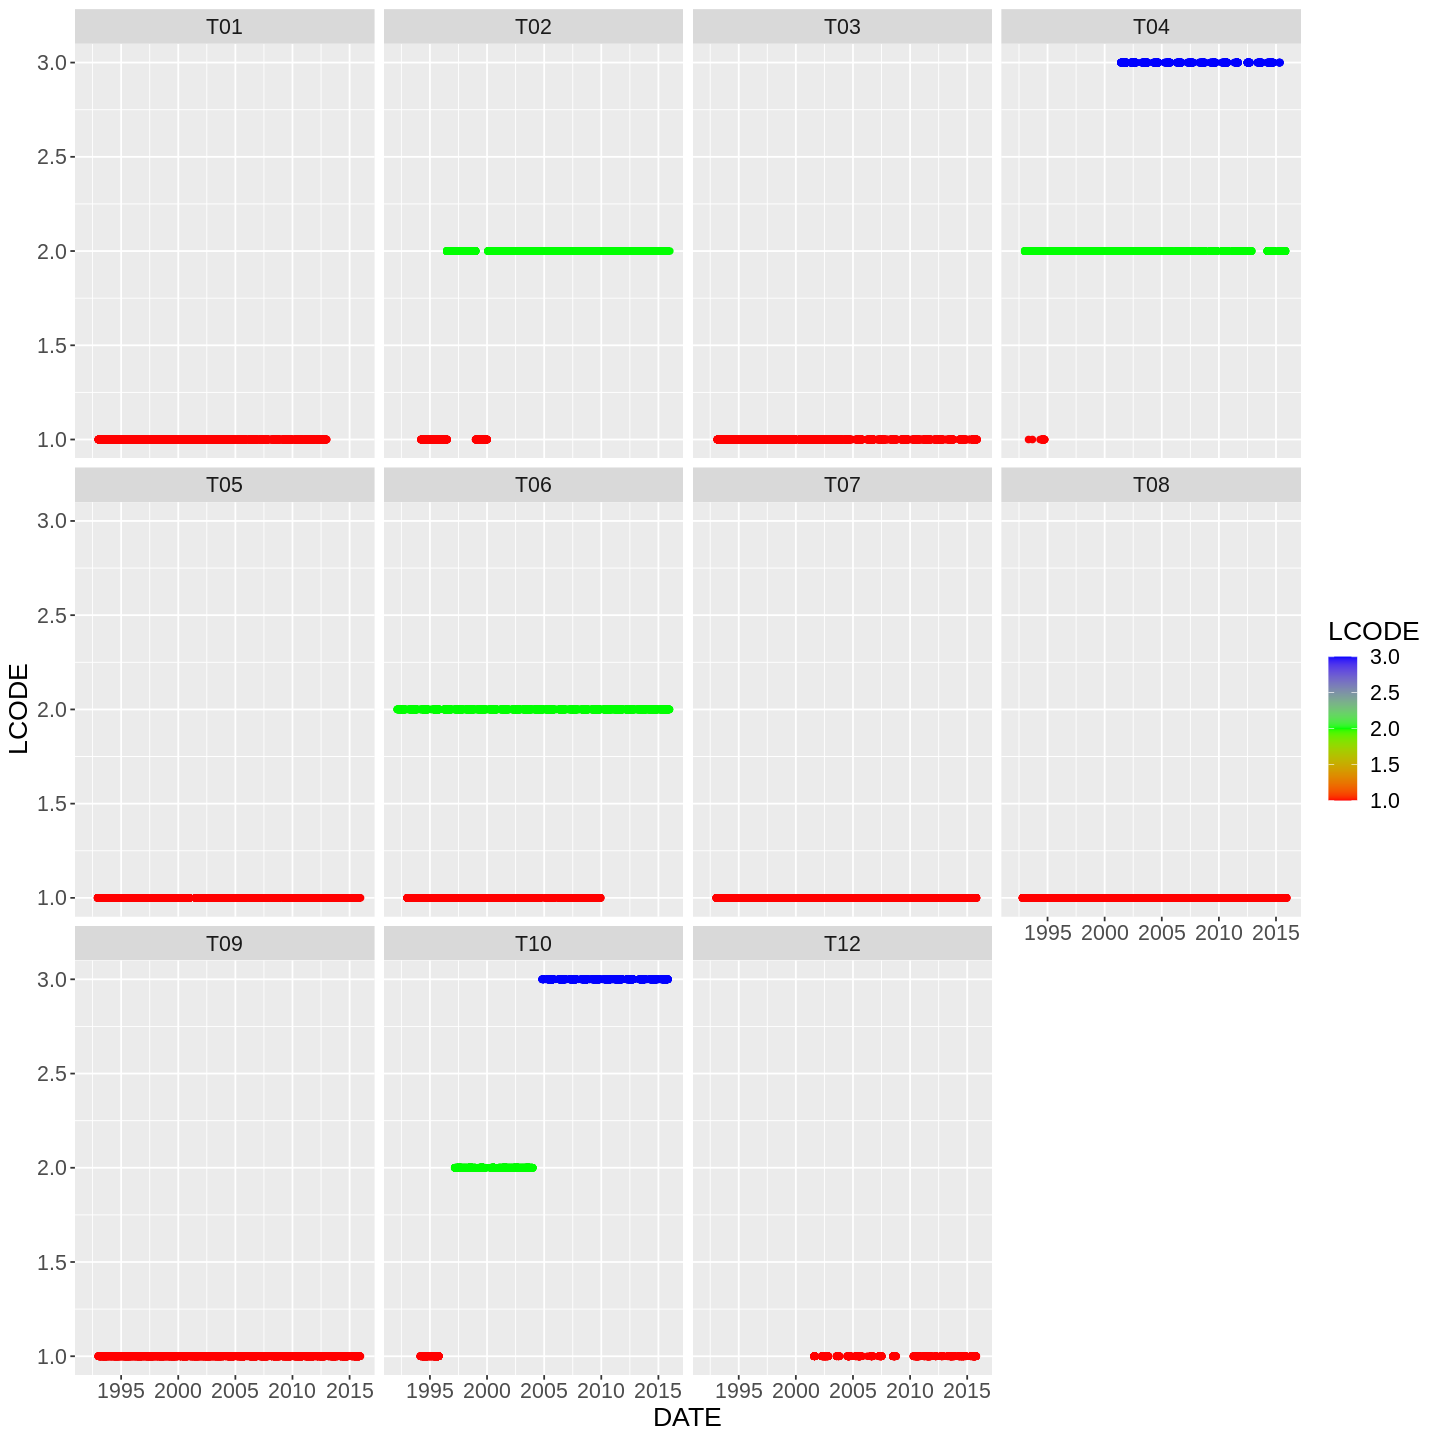

In [4]:
options(repr.plot.width = 12, repr.plot.height = 12)
dd %>%
    ggplot(aes(x=DATE, y=LCODE, color=LCODE)) + 
    geom_point() +
    scale_color_gradientn(colours = rainbow(3)) +
    facet_wrap(SITECODE~.) +
    theme(text = element_text(size=16))

## Determine which sites have overlap
- Sites T02, T04, T06 and T10 have traps at multiple locations
- For site T04 and T06, these locations overlap
- Overlap is a concern as this may present as a jump in abundance of daily moth counts? (Sue, Michael T, Don)

In [5]:
out <- dd %>% 
    # sum over FIELDNAME
    group_by(SITECODE,LCODE,DATE) %>%
    summarize(count = sum(VALUE)) %>%
    ungroup() %>%
    # count row number for DATE,LCODE pair
    count(SITECODE,DATE)
overlap_sites <- unique(out$SITECODE[out$n > 1])
message(
    "The following sites have readings from multiple traps for at least one day:\n", 
    paste(overlap_sites, collapse=" ")
)

# save overlap flag
dd <- dd %>% 
    mutate(overlap_flag = SITECODE %in% overlap_sites)

`summarise()` regrouping output by 'SITECODE', 'LCODE' (override with `.groups` argument)

The following sites have readings from multiple traps for at least one day:
T04 T06



## Calculate daily moth counts
- We sum over LCODE and FIELDNAME to produce **daily counts for each site**
- THIS SUMS OVER MULTIPLE LCODE's

In [6]:
head(dd) 
dd_daily <- dd %>% 
    dplyr::group_by(SITECODE, DATE, overlap_flag) %>%
    dplyr::summarize(count = sum(VALUE)) %>%
    dplyr::ungroup()
head(dd_daily)

SITECODE LCODE FIELDNAME VALUE DATE       overlap_flag
1 T06      2     2542      1     1992-02-24 TRUE        
2 T06      2     929       1     1992-02-24 TRUE        
3 T06      2     2542      1     1992-02-25 TRUE        
4 T06      2     929       1     1992-02-25 TRUE        
5 T06      2     907       1     1992-03-05 TRUE        
6 T06      2     571       1     1992-03-09 TRUE

`summarise()` regrouping output by 'SITECODE', 'DATE' (override with `.groups` argument)



SITECODE DATE       overlap_flag count
1 T01      1993-01-02 FALSE        0    
2 T01      1993-01-03 FALSE        0    
3 T01      1993-01-04 FALSE        0    
4 T01      1993-01-05 FALSE        0    
5 T01      1993-01-06 FALSE        1    
6 T01      1993-01-07 FALSE        1

### Plot daily moth counts for each site
- Sites with overlap coloured **blue**

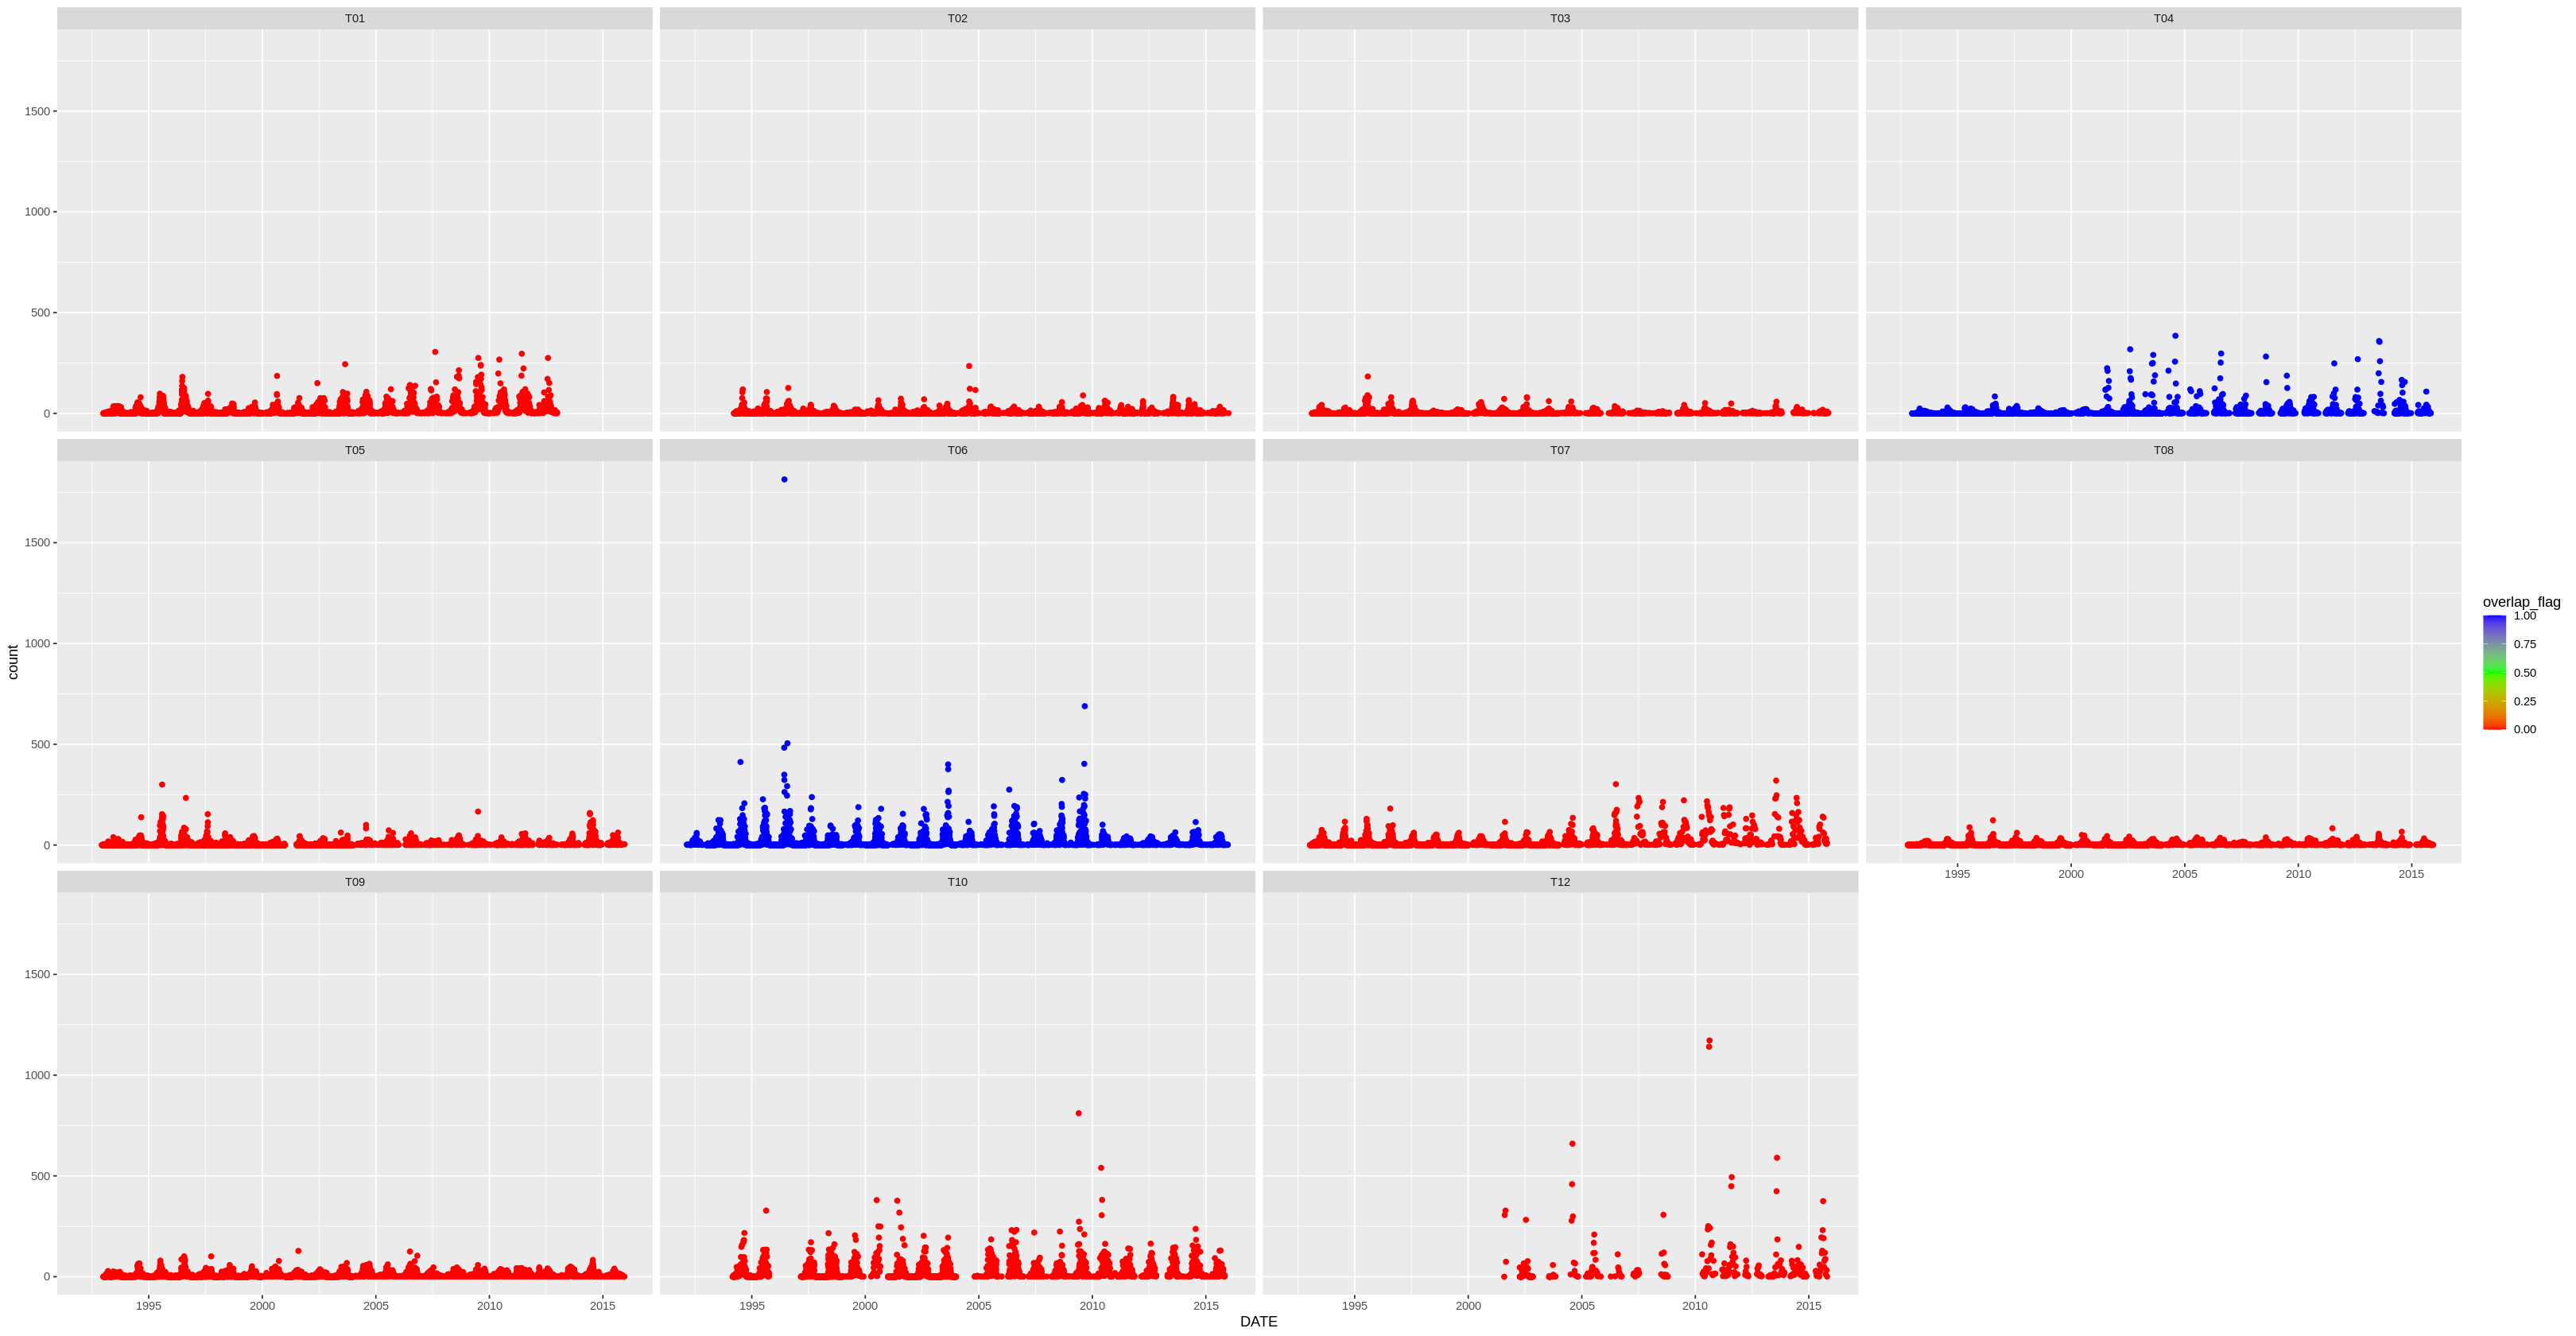

In [7]:
options(repr.plot.width = 27, repr.plot.height = 14)

dd_daily %>%
    mutate(overlap_flag = as.double(overlap_flag)) %>%
    ggplot2::ggplot(aes(x=DATE, y=count, color=overlap_flag)) + 
    geom_point() +
    scale_color_gradientn(colours = rainbow(3)) +
    facet_wrap(SITECODE~.)

## Calculate count by station
- This gives the daily moth counts by each SITECODE-LCODE pair

In [8]:
head(dd)
#head(
options(repr.plot.width = 27, repr.plot.height = 14)
plot_cbs <- dd %>%
    # remove overlap_flag column
    select(!overlap_flag) %>%
    # create station and site_id
    mutate(
        station = paste0(SITECODE, "-", LCODE),
        site_id = sites[SITECODE]
    ) %>%
    # sum over FIELDNAME
    group_by(DATE,station,SITECODE,site_id) %>%
    summarize(count=sum(VALUE)) %>%
    ungroup() %>%
    # plot
    ggplot(aes(x=DATE,y=count, color=site_id)) +
    geom_point() +
    facet_wrap(station~.) +
    scale_color_gradientn(colours = rainbow(3)) +
    theme(text = element_text(size=20))
#)

SITECODE LCODE FIELDNAME VALUE DATE       overlap_flag
1 T06      2     2542      1     1992-02-24 TRUE        
2 T06      2     929       1     1992-02-24 TRUE        
3 T06      2     2542      1     1992-02-25 TRUE        
4 T06      2     929       1     1992-02-25 TRUE        
5 T06      2     907       1     1992-03-05 TRUE        
6 T06      2     571       1     1992-03-09 TRUE

`summarise()` regrouping output by 'DATE', 'station', 'SITECODE' (override with `.groups` argument)



### Plot count by station
- Data between T04-2 and T04-3 looks quite different (Sue/Don/Michael T?)
  - The cause is unknown
  - It could be related to length between consecutive observations (T04-3)
  - It could be a *more attractive* (for moths) station T04-3 typically higher (longer intervals?)
- Similar observations made between T06-1 and T06-2
  - T06-1 typically higher

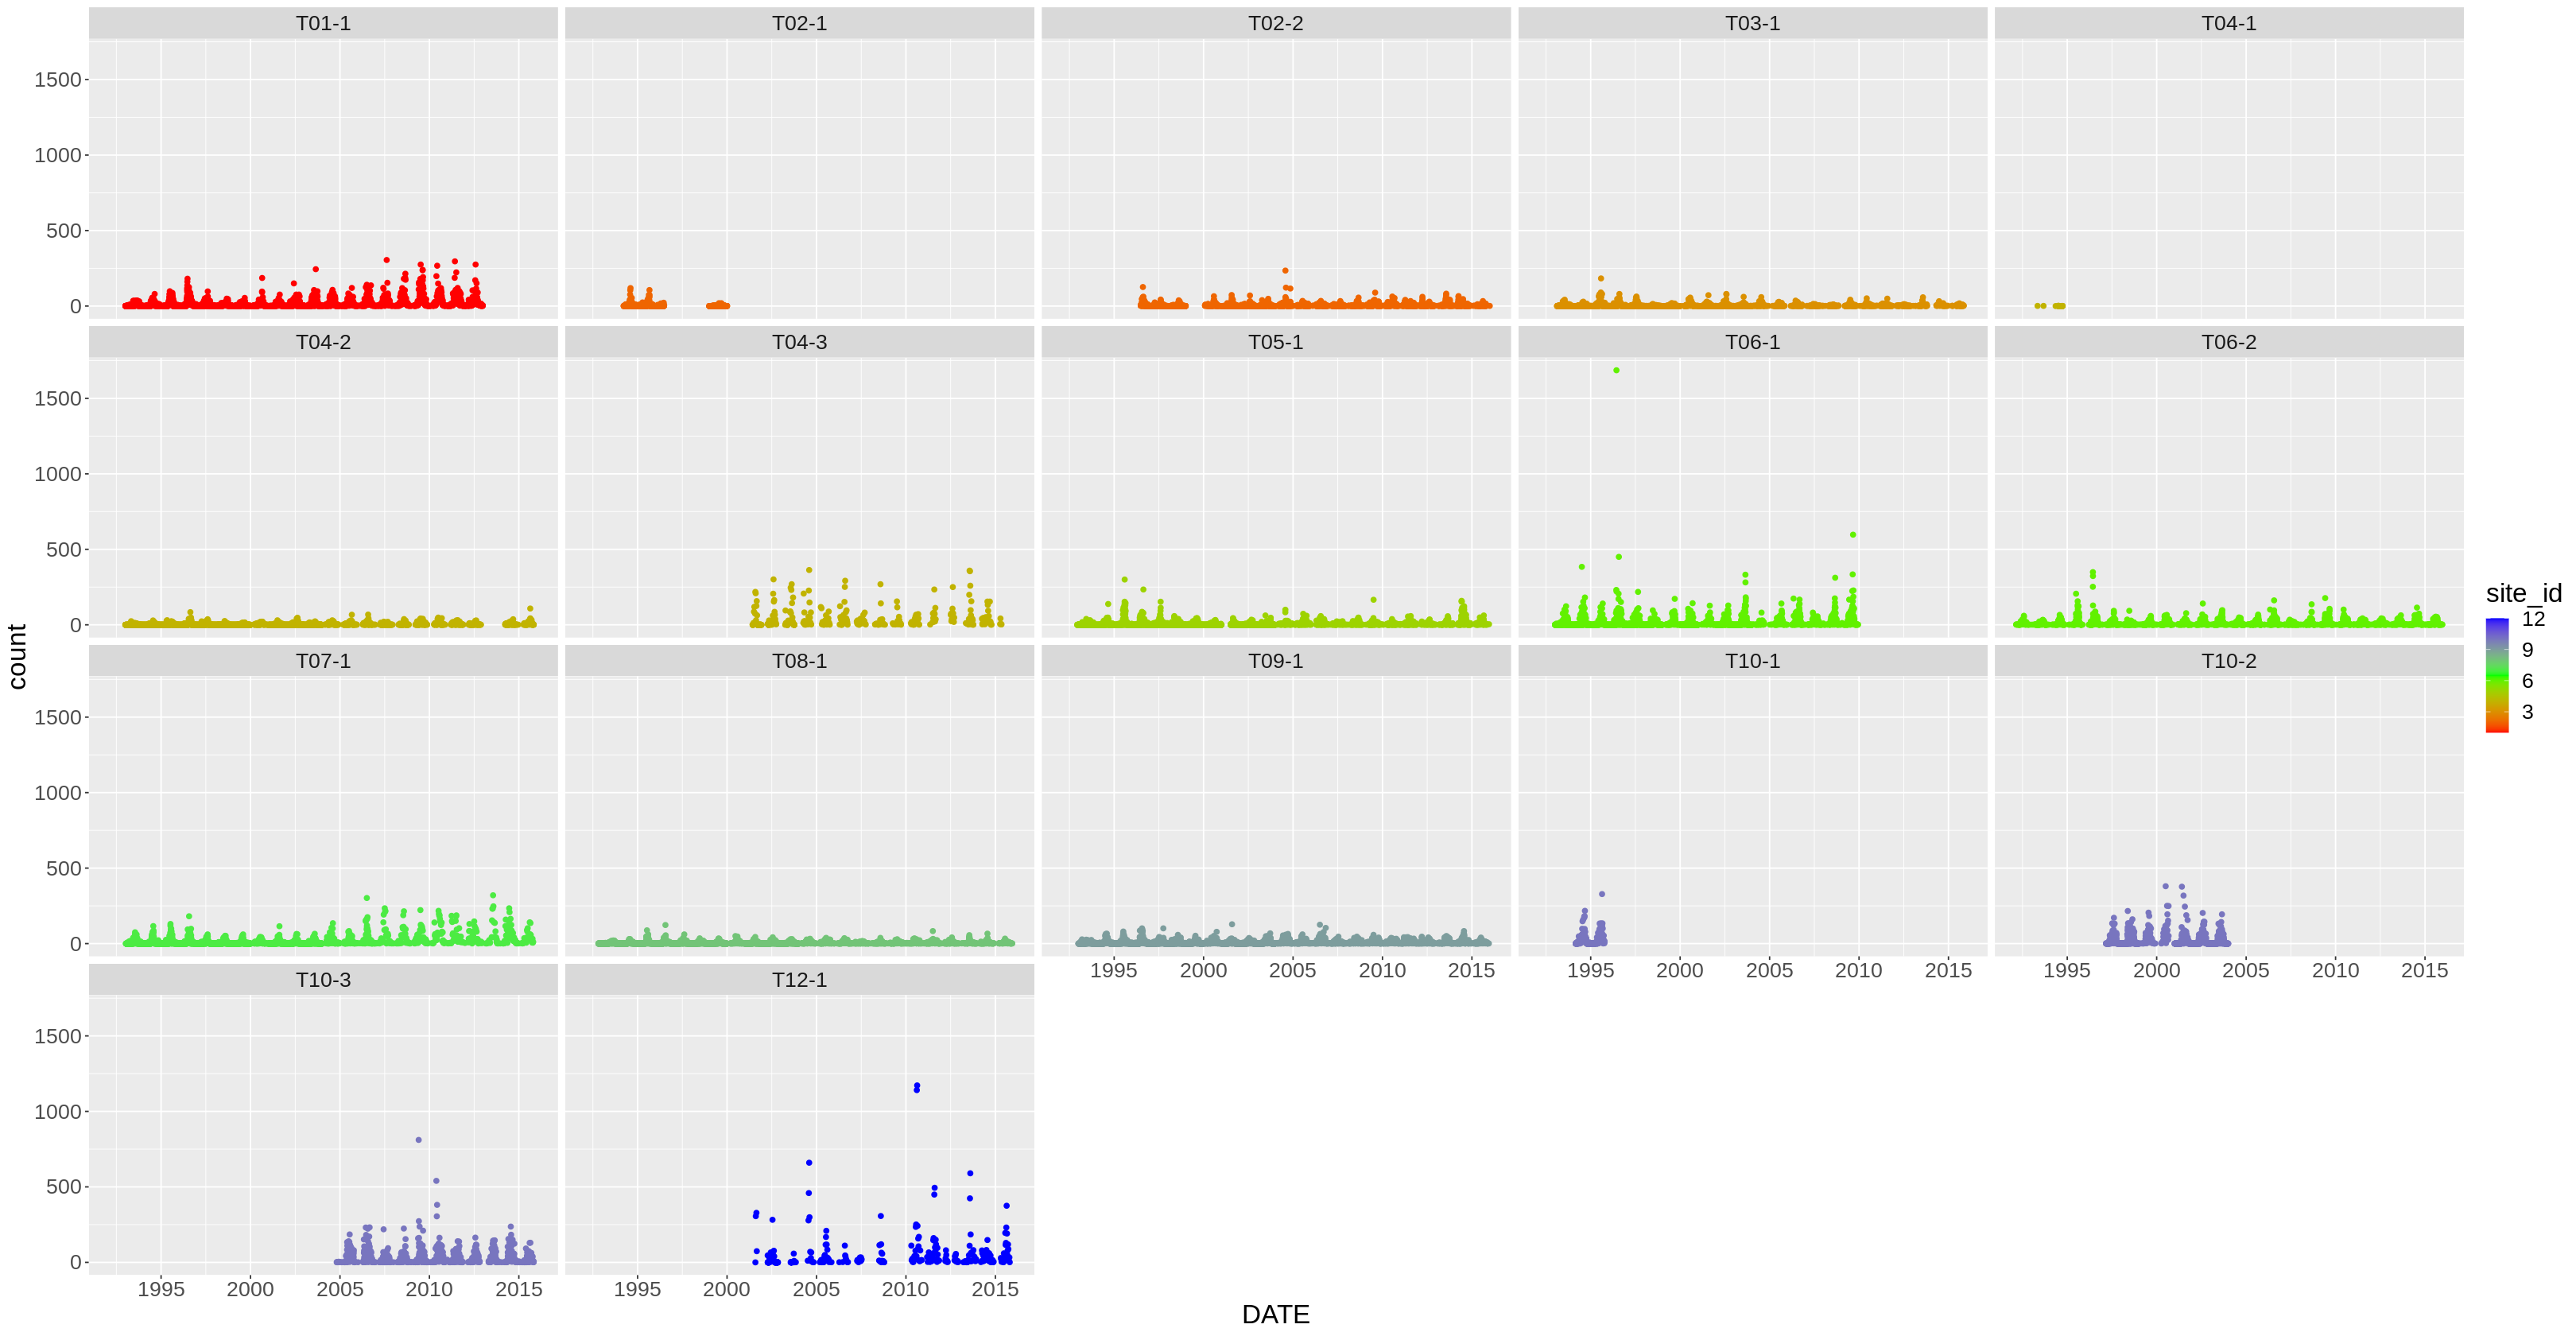

In [9]:
print(plot_cbs)

### Calculate length of interval between counts

In [10]:
head(dd_daily)
dd_daily <- dd_daily %>%
    # order first by SITECODE, then DATE
    arrange(SITECODE, DATE) %>%
    # lag SITECODE, to identify useful rows
    # lag DATE to determine count interval
    mutate(
        lagSITECODE = lag(SITECODE,1),
        lagDATE = lag(DATE,1), 
        interval = as.double(DATE-lagDATE), 
        useful_row = SITECODE==lagSITECODE,
        month = lubridate::month(DATE)
    ) %>%
    # take only useful rows
    filter(useful_row == TRUE)
head(dd_daily)
message("Longest count interval:", max(dd_daily$interval), " days")

SITECODE DATE       overlap_flag count
1 T01      1993-01-02 FALSE        0    
2 T01      1993-01-03 FALSE        0    
3 T01      1993-01-04 FALSE        0    
4 T01      1993-01-05 FALSE        0    
5 T01      1993-01-06 FALSE        1    
6 T01      1993-01-07 FALSE        1

SITECODE DATE       overlap_flag count lagSITECODE lagDATE    interval
1 T01      1993-01-03 FALSE        0     T01         1993-01-02 1       
2 T01      1993-01-04 FALSE        0     T01         1993-01-03 1       
3 T01      1993-01-05 FALSE        0     T01         1993-01-04 1       
4 T01      1993-01-06 FALSE        1     T01         1993-01-05 1       
5 T01      1993-01-07 FALSE        1     T01         1993-01-06 1       
6 T01      1993-01-08 FALSE        0     T01         1993-01-07 1       
  useful_row month
1 TRUE       1    
2 TRUE       1    
3 TRUE       1    
4 TRUE       1    
5 TRUE       1    
6 TRUE       1

Longest count interval:553 days



### Plot the count and interval, colour code by month
-  There seems to have been some change in collection regime around 2004
  - *interval* appears to have a higher variance after 2004
- Disruption to sampling around 2001 (foot and mouth outbreak) can clearly be seen 

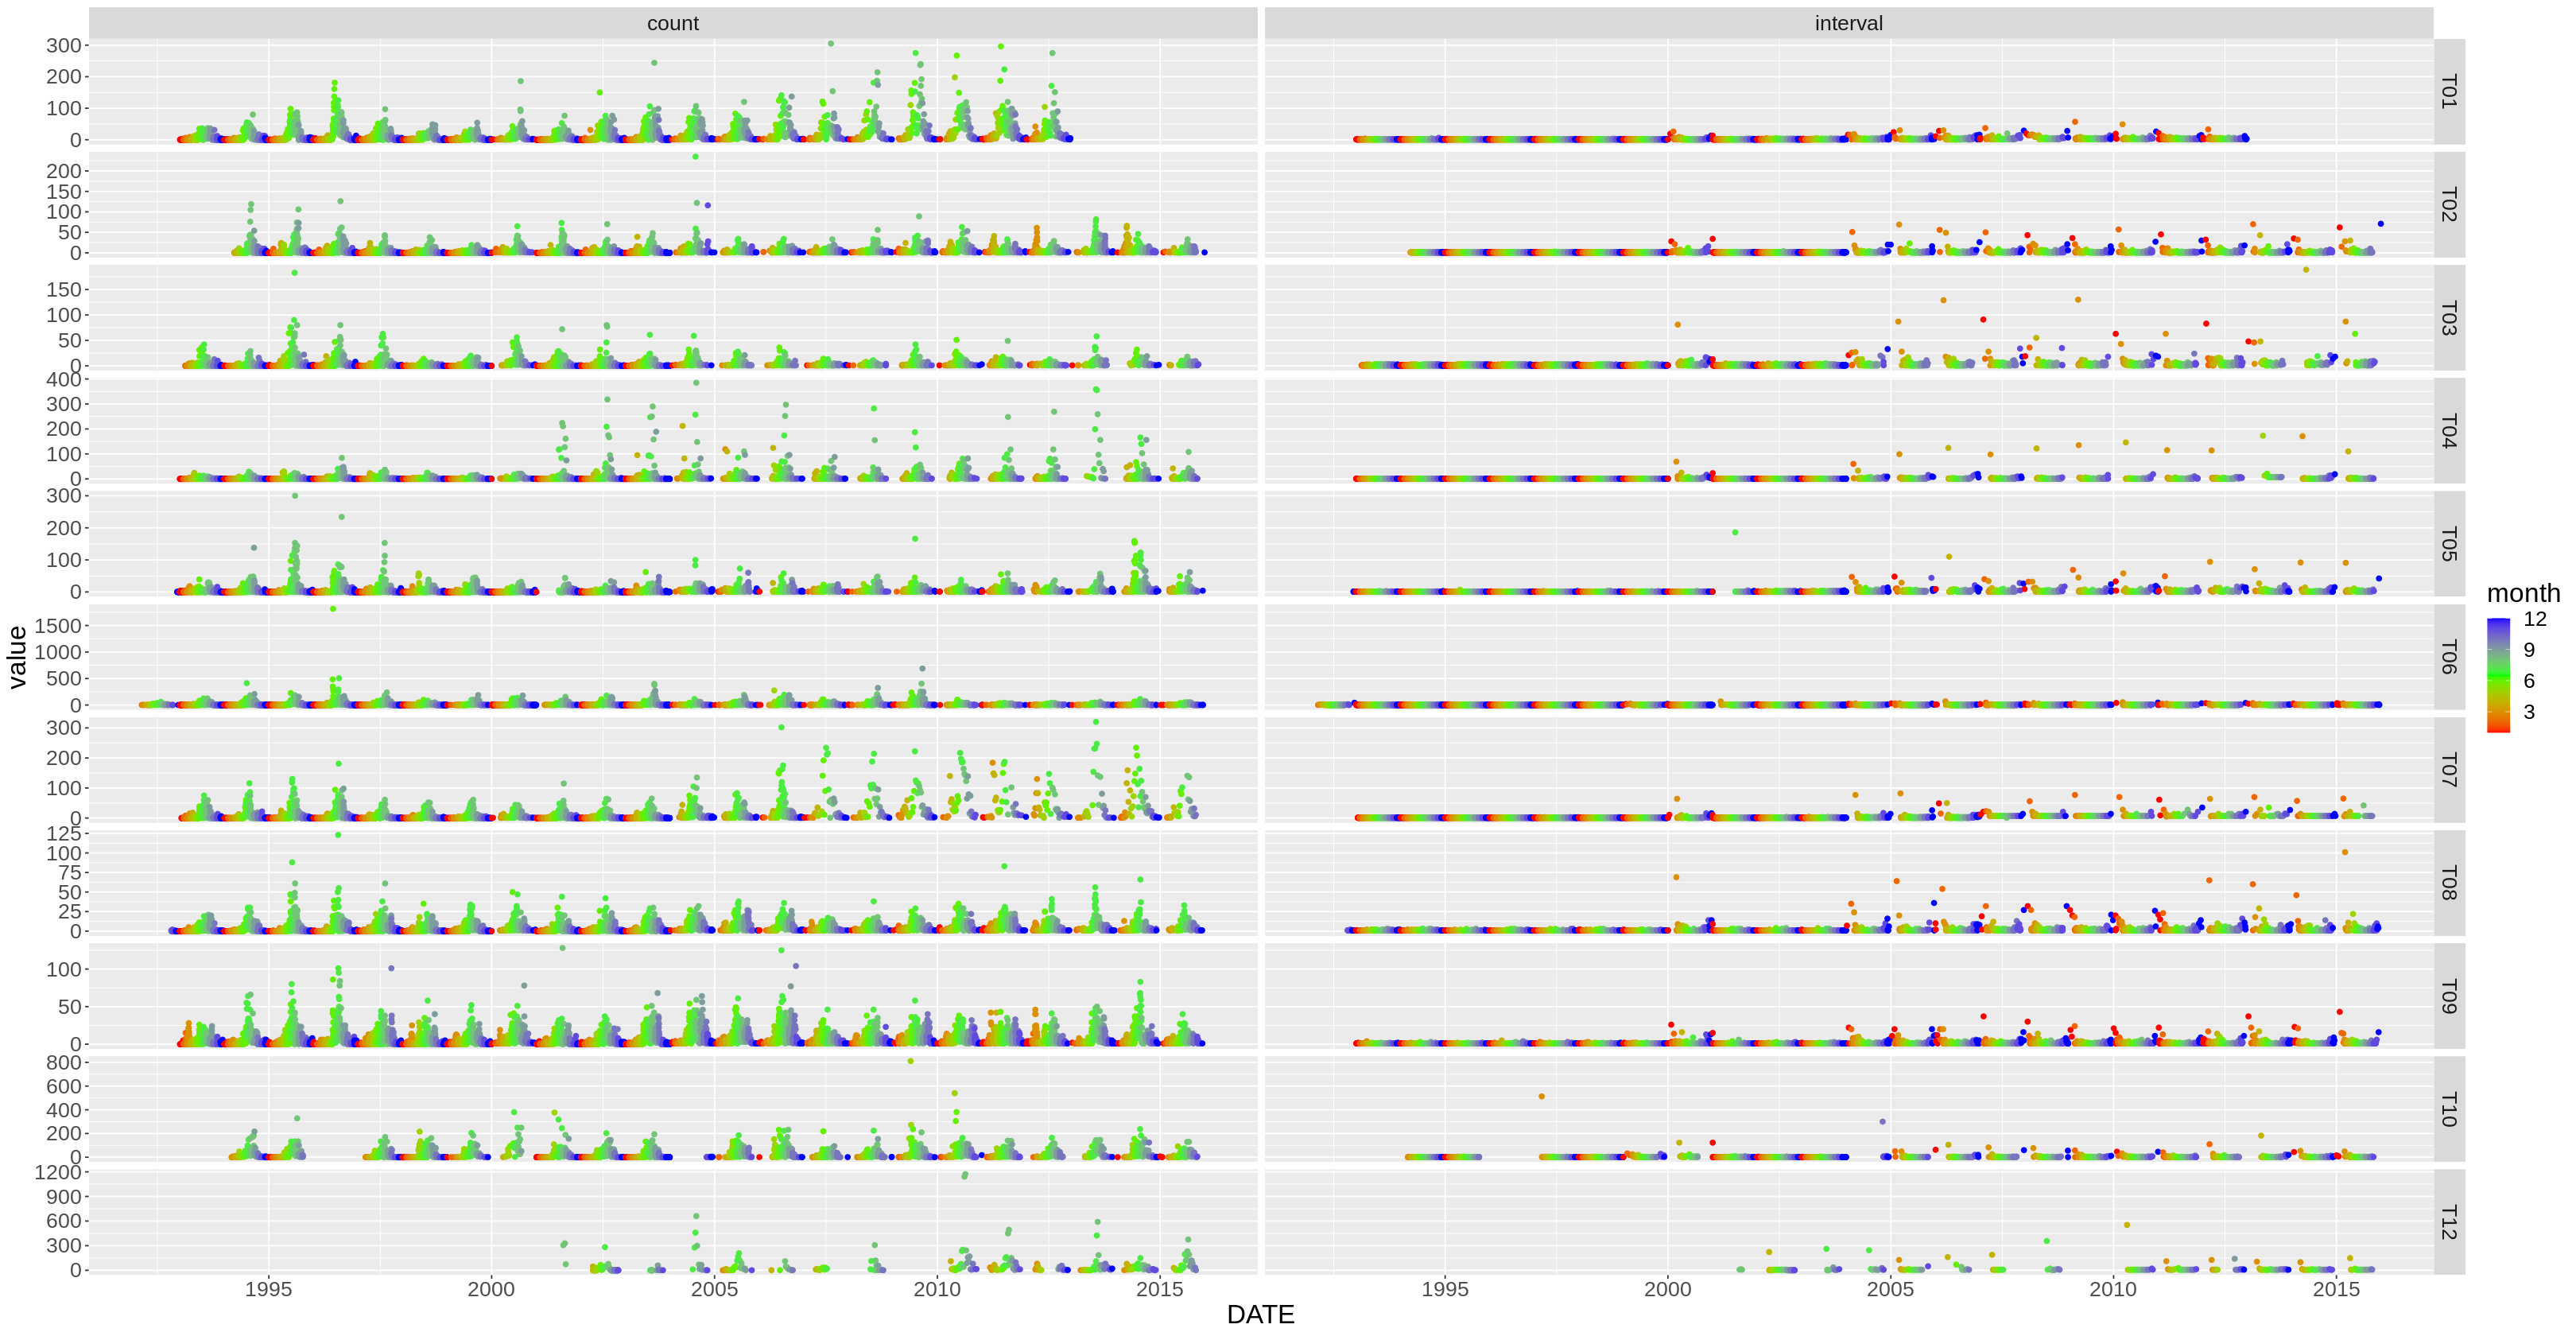

In [11]:
dd_daily %>%
    select(SITECODE,DATE,count,interval,month) %>%
    pivot_longer(
        c(count,interval),
    names_to = "value_type",
    values_to = "value"
    ) %>%
    ggplot2::ggplot(aes(x=DATE, y=value, color=month)) + 
    geom_point() +
    scale_color_gradientn(colours = rainbow(3)) +
    facet_grid(row=vars(SITECODE), col=vars(value_type), scales="free") +
    theme(text = element_text(size=20))

### Plot interval against month
- Many of the **long intervals** correspond to **winter month** (non summer) as they tend to be orange/red/blue in colour

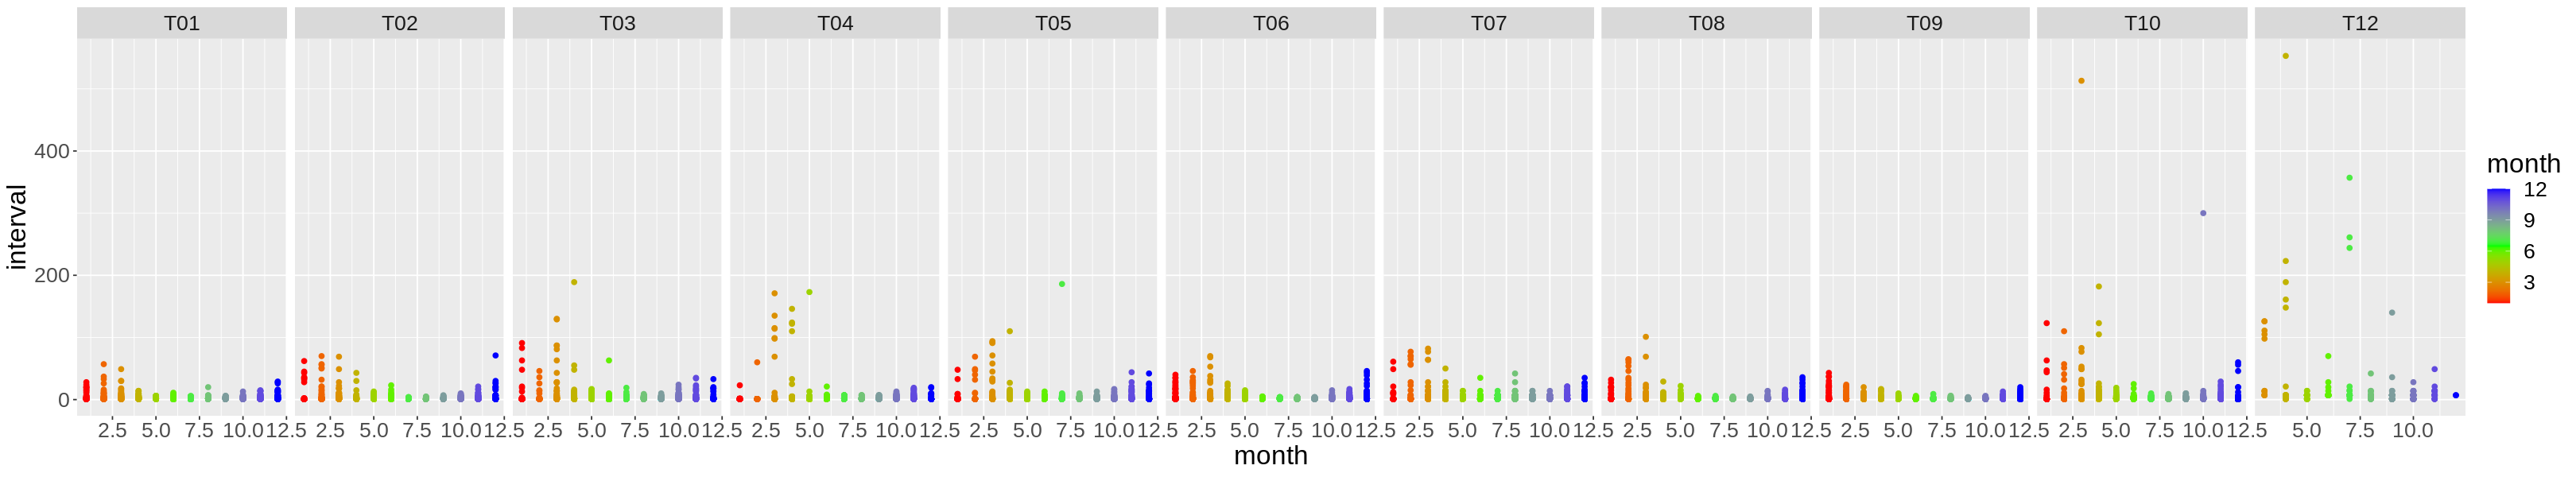

In [12]:
options(repr.plot.width = 27, repr.plot.height = 5)

dd_daily %>%
    ggplot2::ggplot(aes(x=month, y=interval, color=month)) + 
    geom_point() +
    scale_color_gradientn(colours = rainbow(3)) +
    facet_grid(col=vars(SITECODE), scales="free") +
    theme(text = element_text(size=20))

### Plot moth count against month
- Summer months higher count

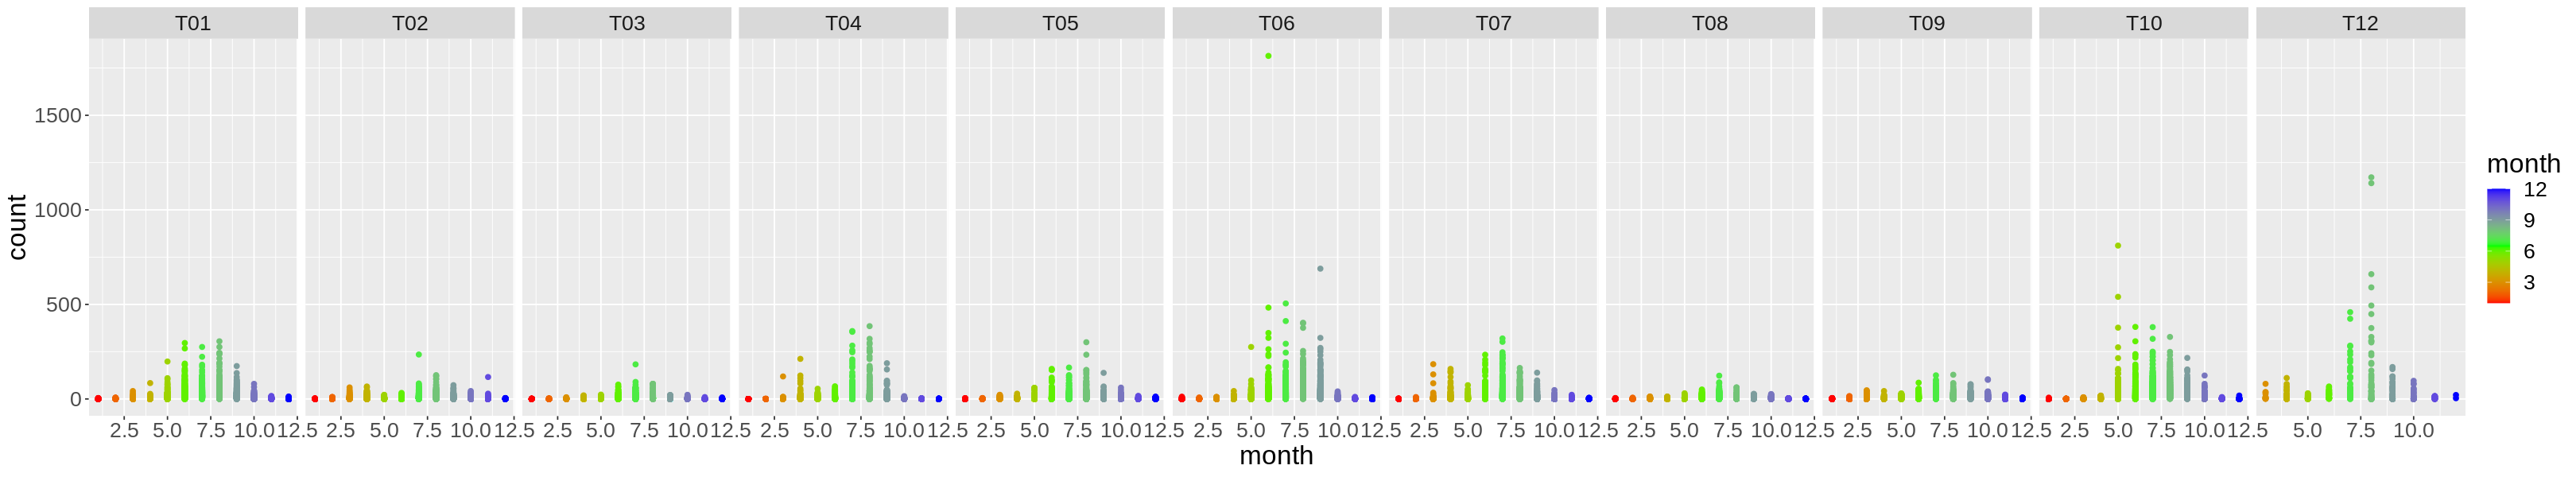

In [13]:
options(repr.plot.width = 27, repr.plot.height = 5)

dd_daily %>%
    ggplot2::ggplot(aes(x=month, y=count, color=month)) + 
    geom_point() +
    scale_color_gradientn(colours = rainbow(3)) +
    facet_grid(col=vars(SITECODE), scales="free") +
    theme(text = element_text(size=20))

### Calculate daily moth rates
-  The idea here is that sometimes days pass when moths are not collected. If this leads to a *build-up* of moths, it may be better to work with a rate (moth count/count interval).
-  Typically, the largest intervals correspond to the winter months, and the highest counts correspond to the summer months. Let $C_t$ denote the moth count at time $t$, and $I_t$ denote the number of days that have passed between observing $C_t$ and $C_{t-1}$, then, the *count rate*, $R_t = \frac{C_t}{I_t}$ maybe a suitable measure for us to proceed with
- **I think that it is very important that some sort of sensitivy analysis is carried out to determine how much** $I_t$ **affects** $R_t$


In [14]:
dd_daily <- dd_daily %>%
    mutate(rate = count/interval)
head(dd_daily)

SITECODE DATE       overlap_flag count lagSITECODE lagDATE    interval
1 T01      1993-01-03 FALSE        0     T01         1993-01-02 1       
2 T01      1993-01-04 FALSE        0     T01         1993-01-03 1       
3 T01      1993-01-05 FALSE        0     T01         1993-01-04 1       
4 T01      1993-01-06 FALSE        1     T01         1993-01-05 1       
5 T01      1993-01-07 FALSE        1     T01         1993-01-06 1       
6 T01      1993-01-08 FALSE        0     T01         1993-01-07 1       
  useful_row month rate
1 TRUE       1     0   
2 TRUE       1     0   
3 TRUE       1     0   
4 TRUE       1     1   
5 TRUE       1     1   
6 TRUE       1     0

### Plot count and rate
- The count rate does appears to be much more stable than the count
 - Sites including T01, T07 and arguably T09 appear to be most affected
 - A number of spuriously high counts at sites T03,T05 and T08 seem to be *corrected* (use with caution) by dividing through by the interval
- The rate and count for sites T02,T03,T08 and T09 appear to be the most similar, maybe further analysis should begin with these sites
 - I believe T02, T08 and T09 are the sites that Don has suggested analysing previously (in 3-Compare-Sites notebook)
 - Maybe these observation can be used to support this

SITECODE DATE       overlap_flag count lagSITECODE lagDATE    interval
1 T01      1993-01-03 FALSE        0     T01         1993-01-02 1       
2 T01      1993-01-04 FALSE        0     T01         1993-01-03 1       
3 T01      1993-01-05 FALSE        0     T01         1993-01-04 1       
4 T01      1993-01-06 FALSE        1     T01         1993-01-05 1       
5 T01      1993-01-07 FALSE        1     T01         1993-01-06 1       
6 T01      1993-01-08 FALSE        0     T01         1993-01-07 1       
  useful_row month rate
1 TRUE       1     0   
2 TRUE       1     0   
3 TRUE       1     0   
4 TRUE       1     1   
5 TRUE       1     1   
6 TRUE       1     0

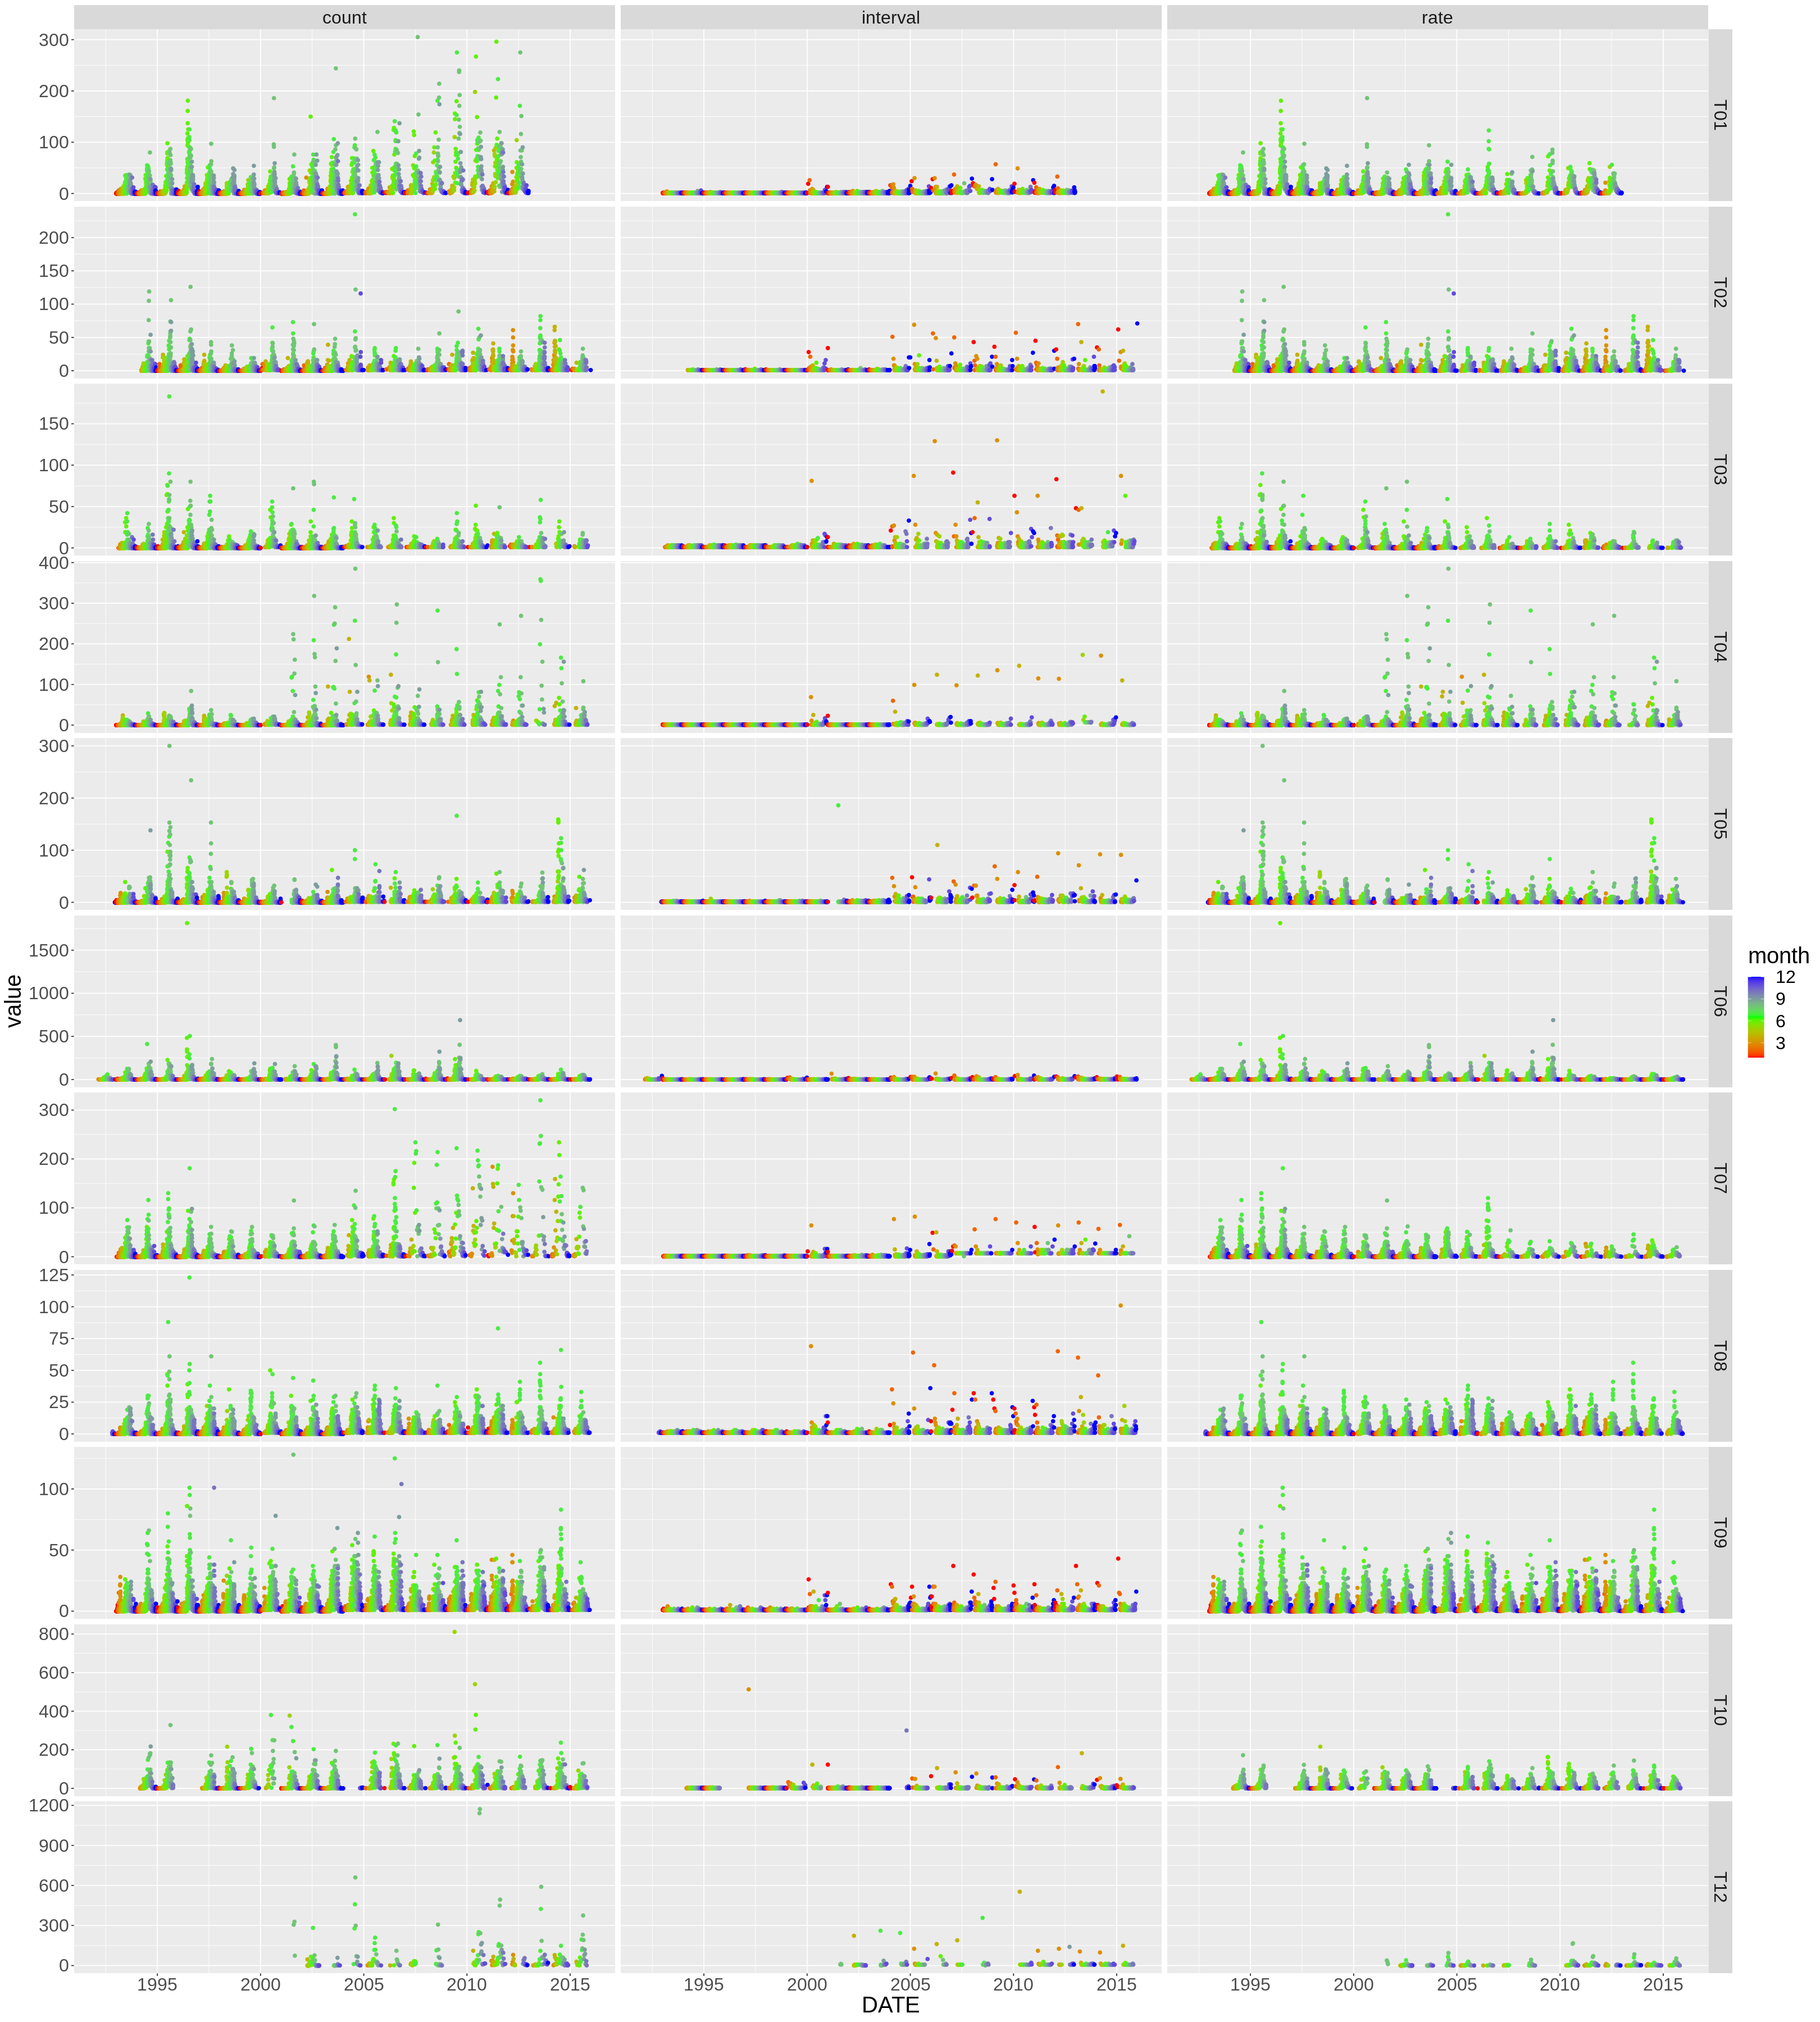

In [15]:
options(repr.plot.width = 27, repr.plot.height = 30)

head(dd_daily)
dd_daily %>%
    select(SITECODE,DATE,count,interval,rate,month) %>%
    pivot_longer(
        c(count,rate,interval),
        names_to = "value_type",
        values_to = "value"
    ) %>%
ggplot2::ggplot(aes(x=DATE, y=value, color=month)) + 
geom_point() +
scale_color_gradientn(colours = rainbow(3)) +
facet_grid(row=vars(SITECODE), col=vars(value_type), scales="free_y") +
theme(text = element_text(size=24))

### Plot count Vs rate
- The sites with the largest *visual* difference between count and rate (T01 and T07) are clear in the plot below
- The diagnol trajectories are determined by the magnitute of the interval
 - Solid line, interval = 1
 - Dashed line, interval = 2
 - Dotted line, interval = 3

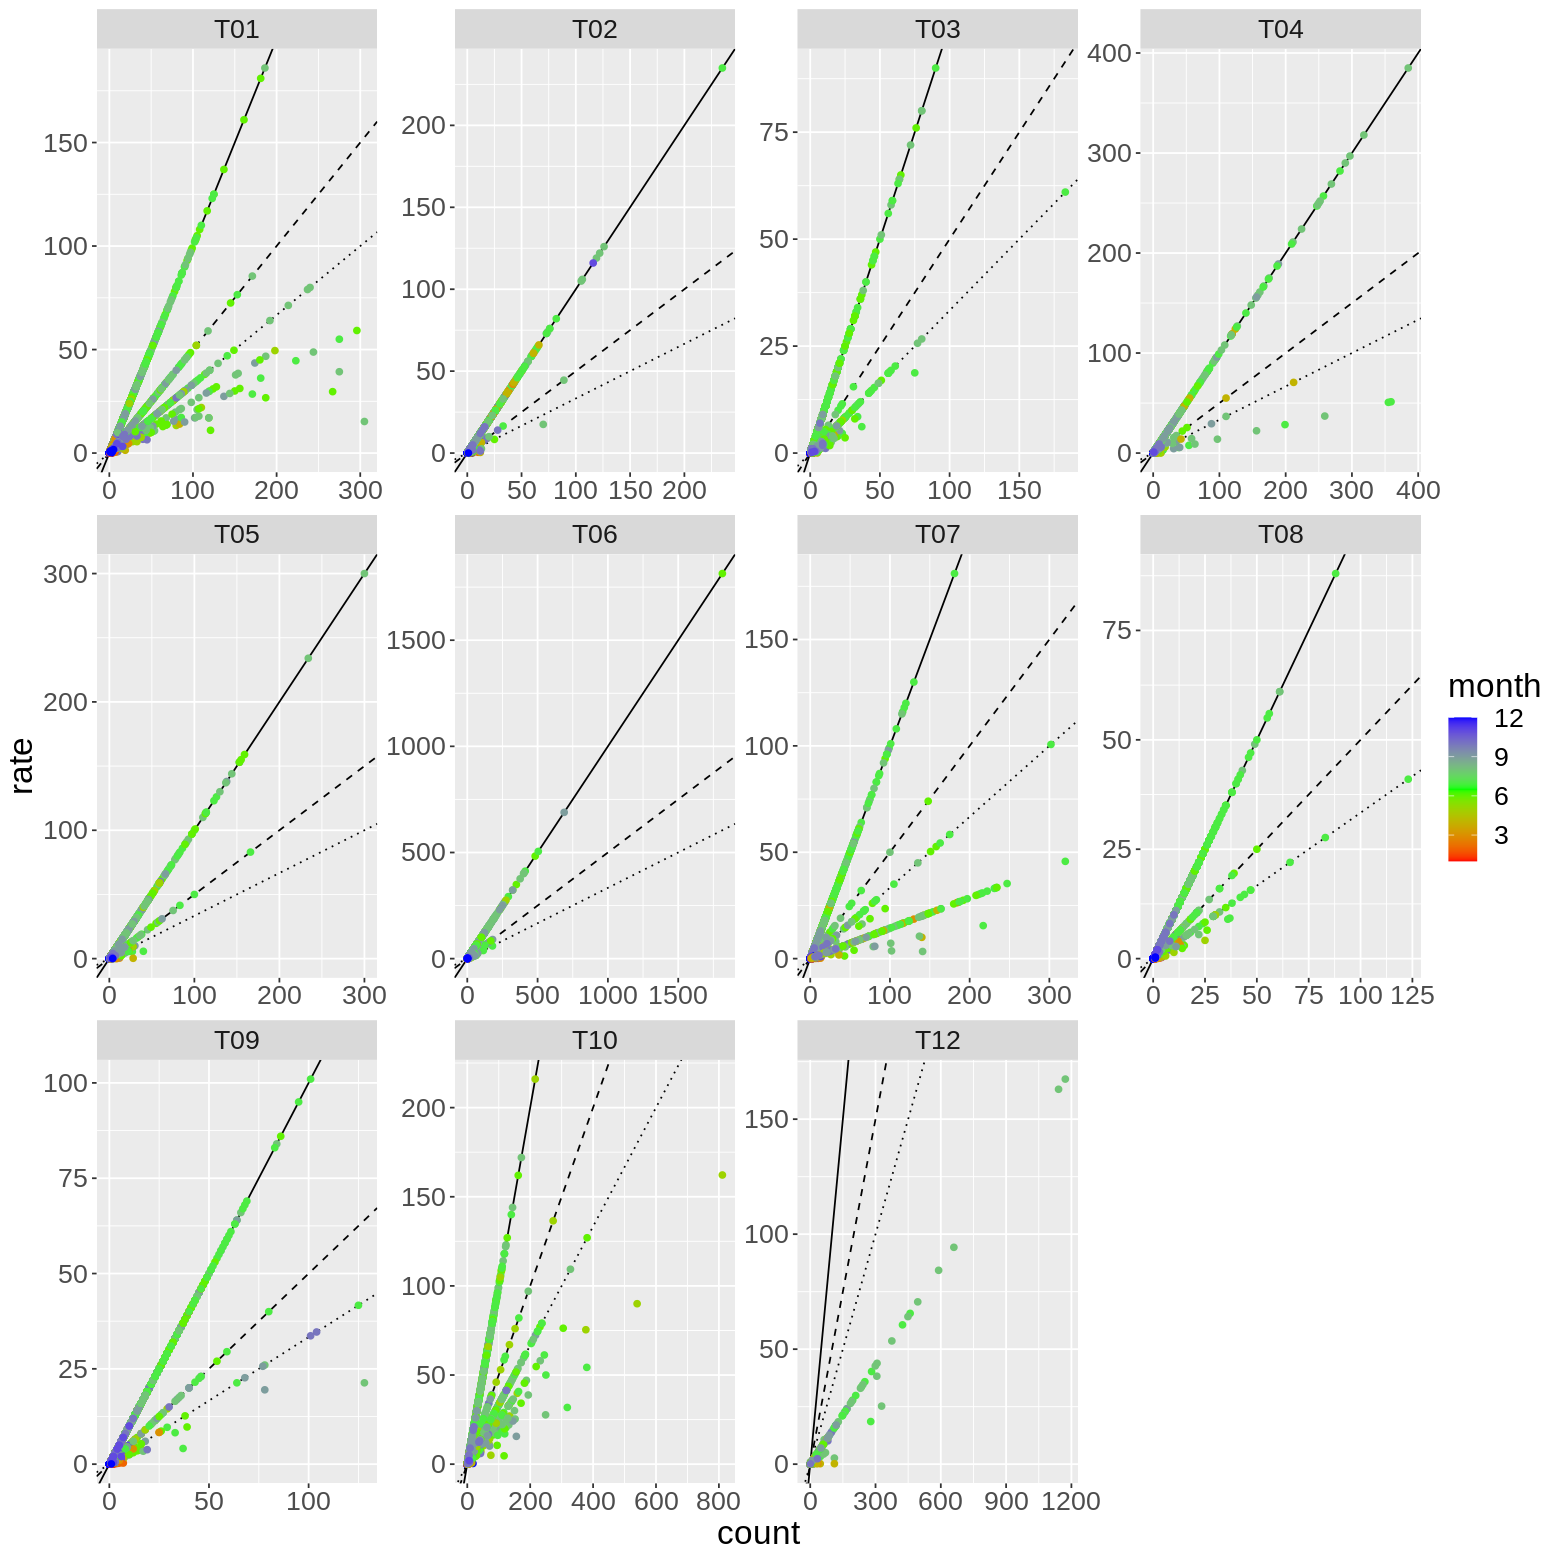

In [16]:
options(repr.plot.width = 13, repr.plot.height = 13)

dd_daily %>%
    select(SITECODE,count,interval,rate,month) %>%
    # plot
    ggplot2::ggplot(aes(x=count, y=rate, color=month)) + 
    geom_abline(slope=1,intercept=0, linetype=1) +
    geom_abline(slope=1/2,intercept=0, linetype=2) +
    geom_abline(slope=1/3,intercept=0, linetype=3) +
    geom_point() +
    scale_color_gradientn(colours = rainbow(3)) +
    facet_wrap(~SITECODE, scales='free') +
    theme(text = element_text(size=20))

### Plot histogram of intervals (distribution of interval magnitude)

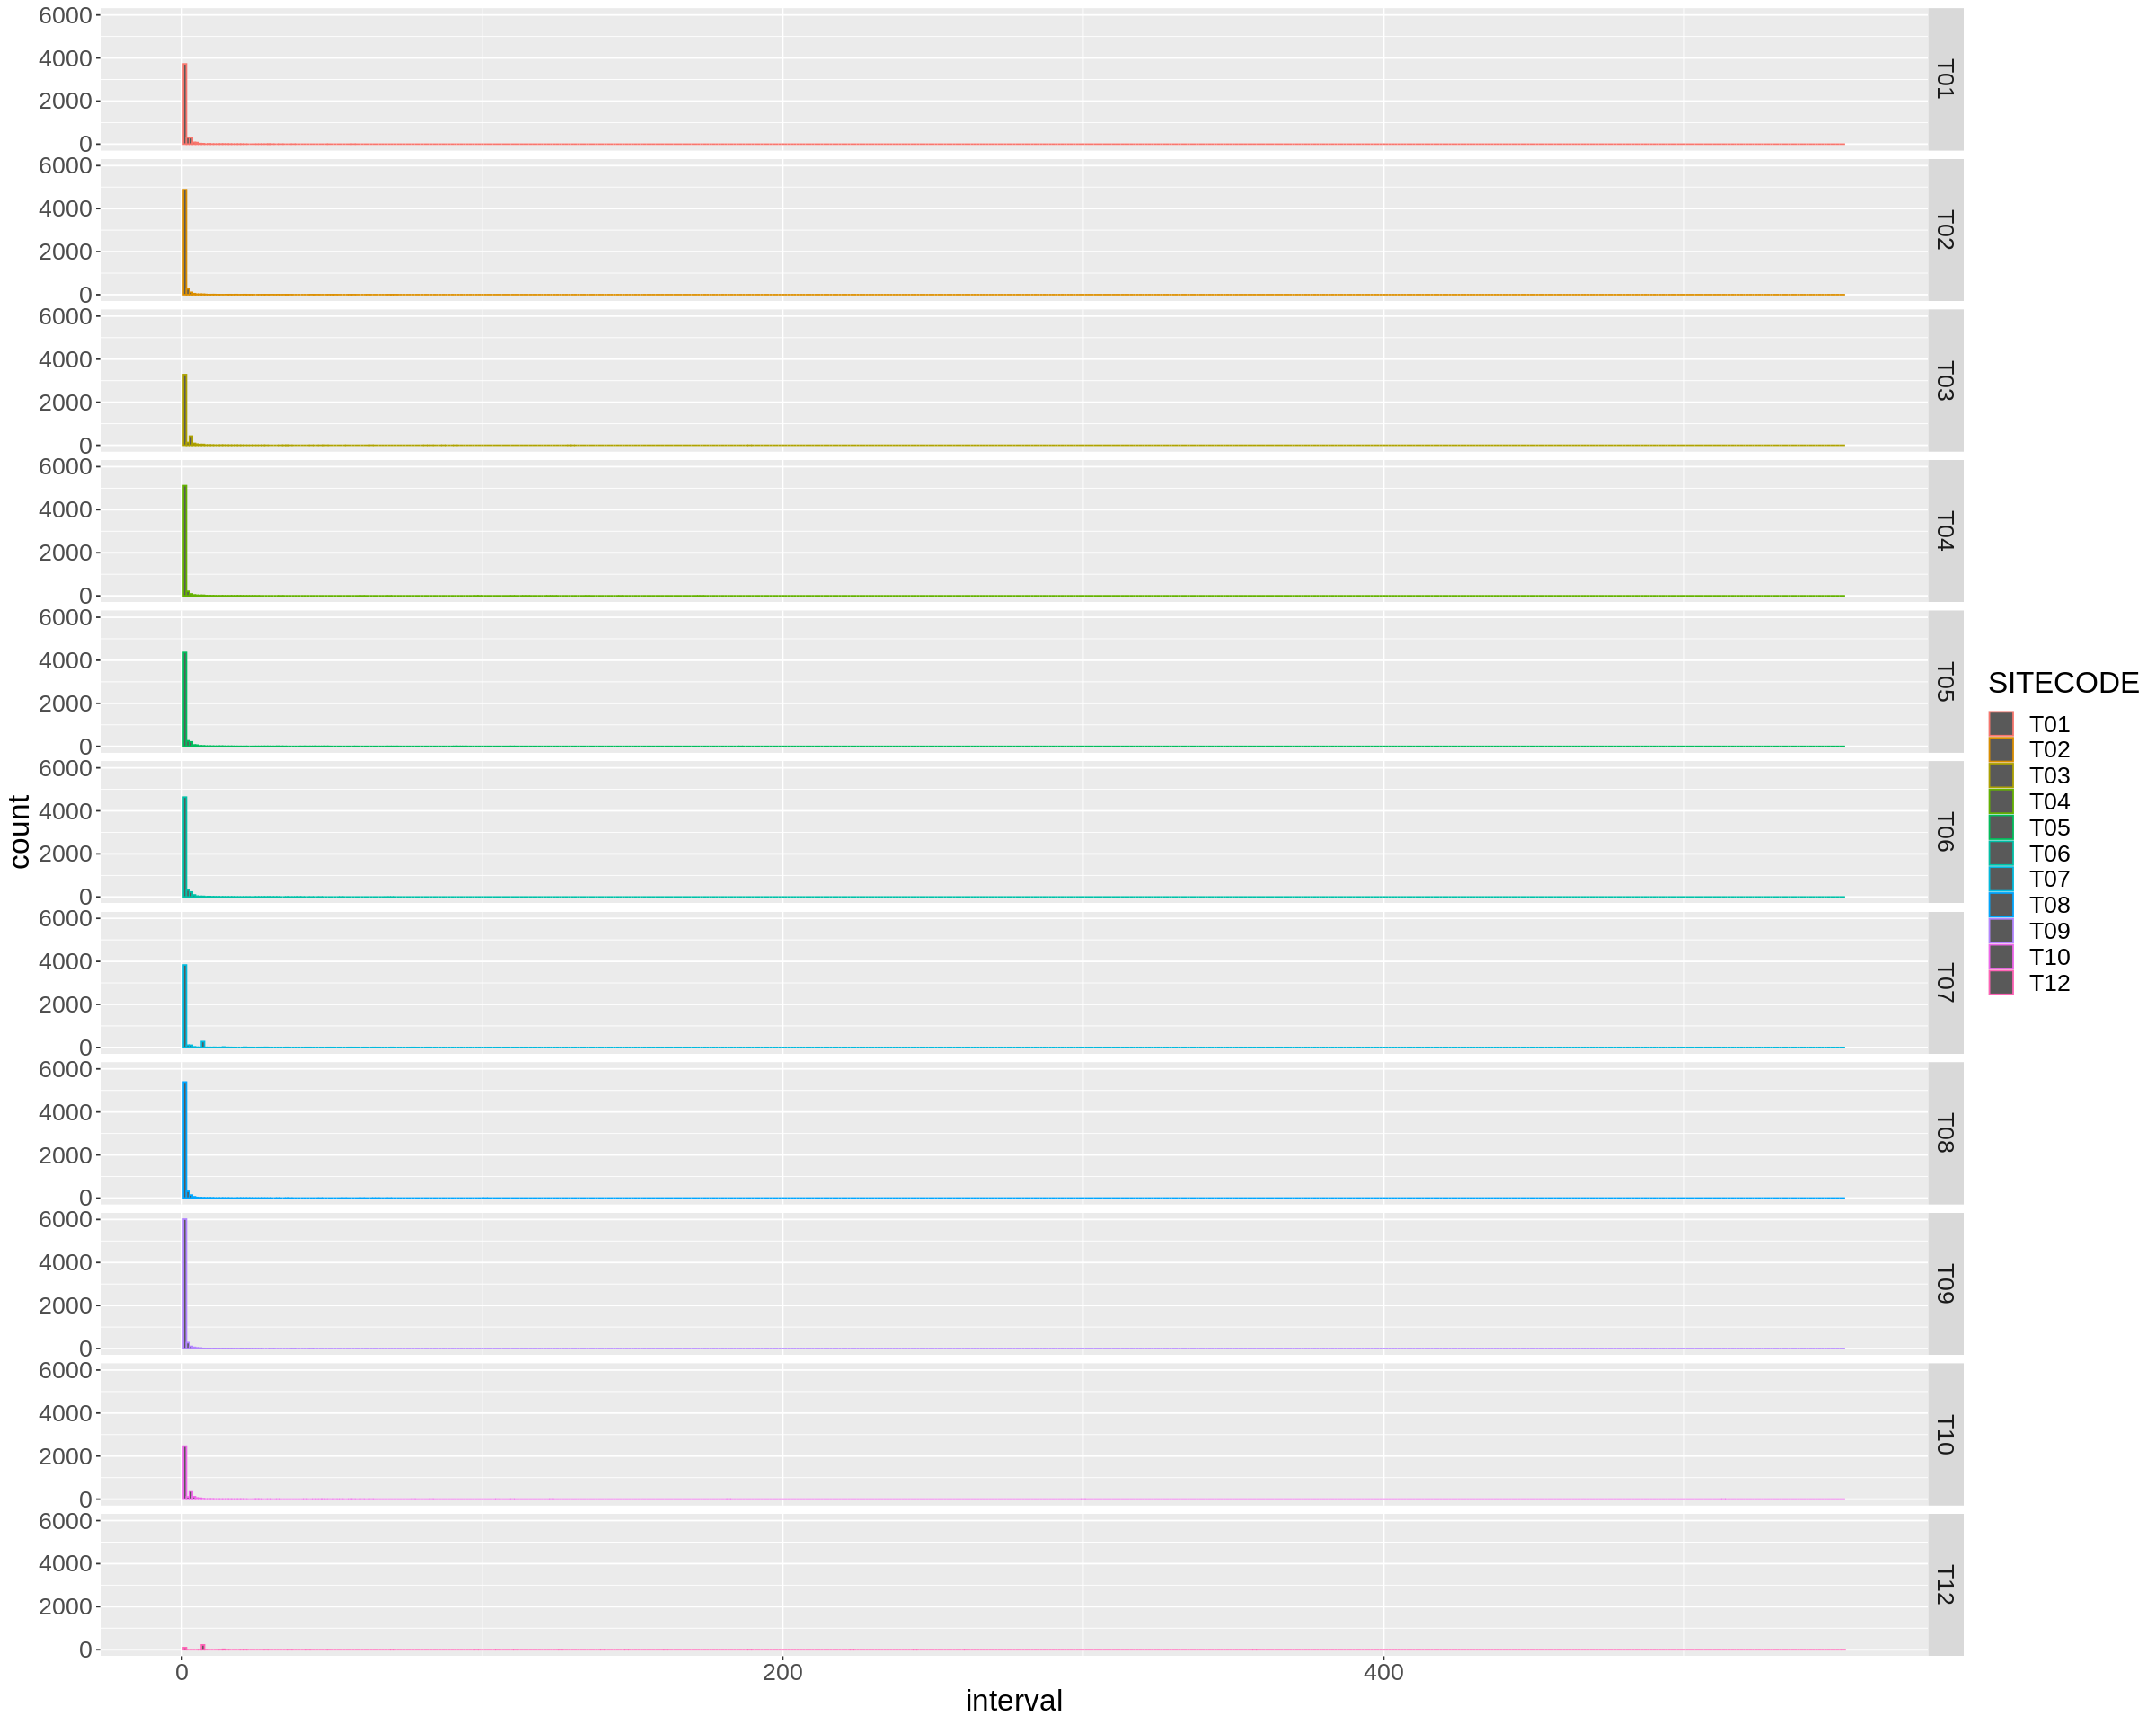

In [17]:
options(repr.plot.width = 20, repr.plot.height = 16)
dd_daily %>%
    ggplot2::ggplot(aes(x=interval, color=SITECODE)) + 
    geom_histogram(center=0, binwidth=1) +
    facet_grid(rows=vars(SITECODE)) +
    theme(text = element_text(size=20))

### Just consider all days with interval == 1?
- As we saw earlier, the higher intervals typically correspond to the winter months meaning we subsequently remove the data over winter months
- This is clear for sites T02,T08 and T09
 - As after 2004, there appears to be a step in the counts; not very many of them close to 0

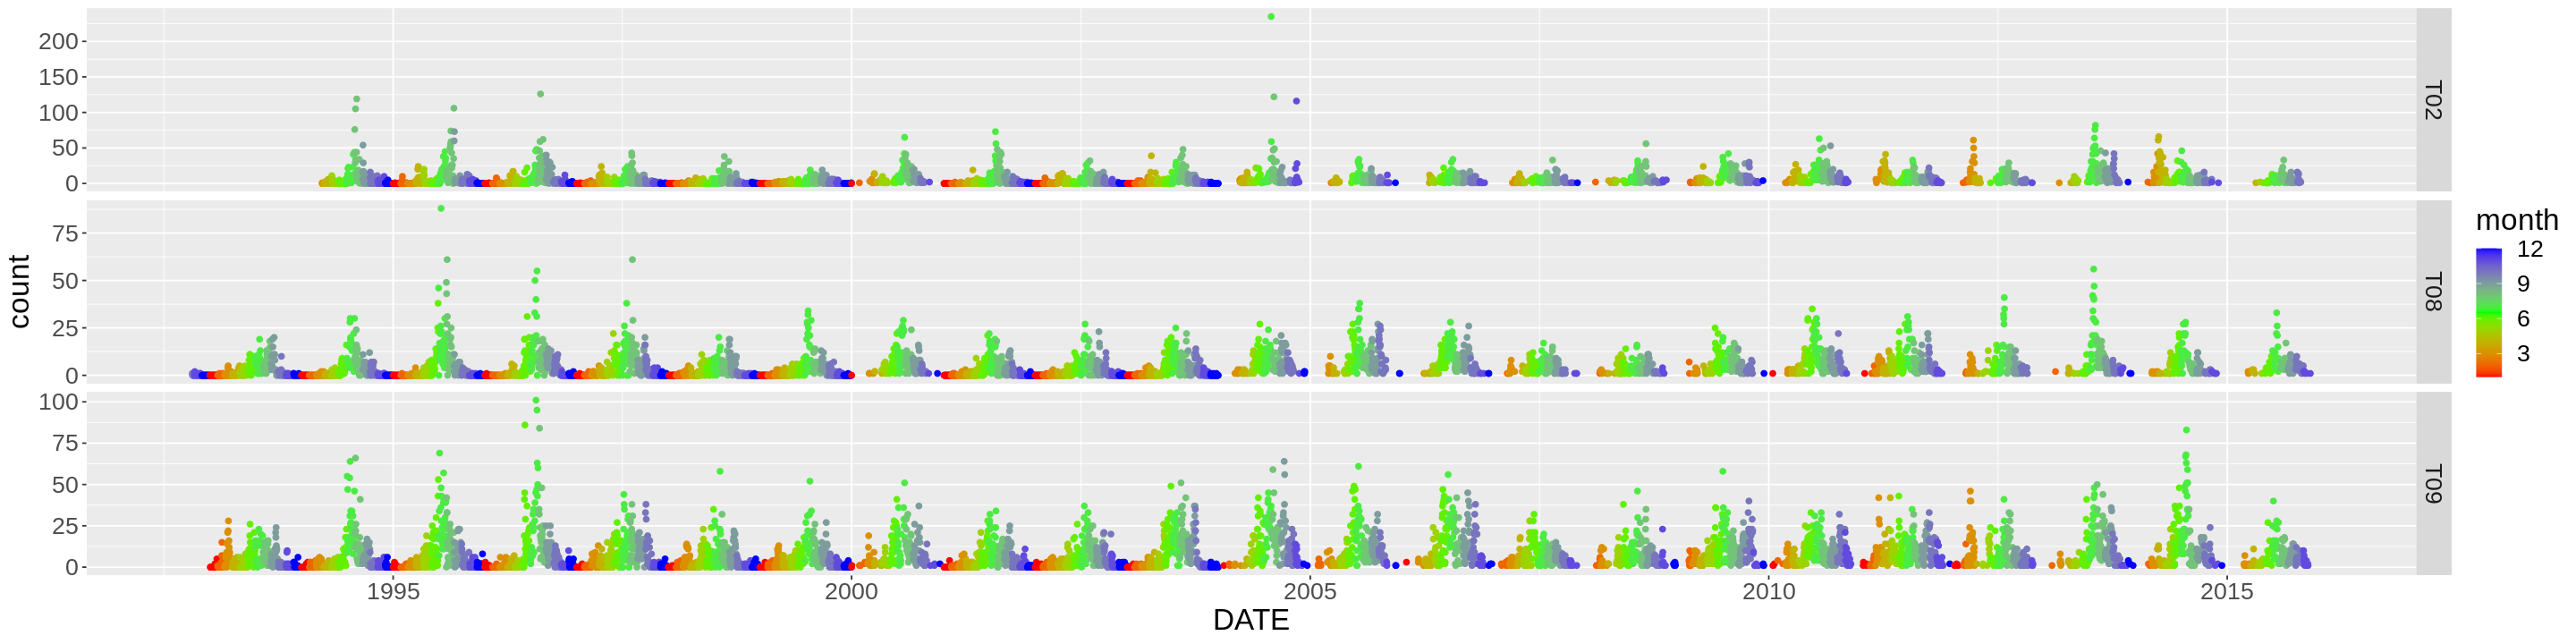

In [18]:
options(repr.plot.width = 24, repr.plot.height = 6)

dd_daily %>%
    filter(
        interval==1, 
        SITECODE %in% paste0("T0", c(2,8,9))
    ) %>%
    ggplot2::ggplot(aes(x=DATE, y=count, color=month)) + 
    geom_point() +
    scale_color_gradientn(colours = rainbow(3)) +
    facet_grid(row=vars(SITECODE), scales="free") +
    theme(text = element_text(size=20))

# Proceeding with safe stations only
- We will reapply some of the analysis above to the safe stations
- This erradicates the concern of having counts from multiple locations for a given site
- This excludes T10 due to the 3 (significant) stations associated with SITECODE=10
- Remove T12 as the data looked sparse (in comaprison to other sites) and data much more recent

In [19]:
head(dd)
safe_stations <- c("T01-1", "T02-2", "T03-1", "T04-2", "T05-1", "T06-2", "T07-1", "T08-1", "T09-1")

tbl_safestations <- dd %>%
    select(SITECODE, LCODE, FIELDNAME, VALUE, DATE) %>%
    mutate(station = paste0(SITECODE, "-", LCODE)) %>%
    filter(station %in% safe_stations)
head( tbl_safestations )
print( sort(unique(tbl_safestations$station)) )

SITECODE LCODE FIELDNAME VALUE DATE       overlap_flag
1 T06      2     2542      1     1992-02-24 TRUE        
2 T06      2     929       1     1992-02-24 TRUE        
3 T06      2     2542      1     1992-02-25 TRUE        
4 T06      2     929       1     1992-02-25 TRUE        
5 T06      2     907       1     1992-03-05 TRUE        
6 T06      2     571       1     1992-03-09 TRUE

SITECODE LCODE FIELDNAME VALUE DATE       station
1 T06      2     2542      1     1992-02-24 T06-2  
2 T06      2     929       1     1992-02-24 T06-2  
3 T06      2     2542      1     1992-02-25 T06-2  
4 T06      2     929       1     1992-02-25 T06-2  
5 T06      2     907       1     1992-03-05 T06-2  
6 T06      2     571       1     1992-03-09 T06-2

[1] "T01-1" "T02-2" "T03-1" "T04-2" "T05-1" "T06-2" "T07-1" "T08-1" "T09-1"


## Calculate daily interval

In [20]:
head(tbl_safestations)
tbl_safestations <- tbl_safestations %>%
#    # sum over FIELDNAME (moth species)
    group_by(station, DATE) %>%
    summarize(count = sum(VALUE)) %>%
    ungroup() %>%
    # order first by station, then DATE
    arrange(station, DATE) %>%
    # lag SITECODE, to identify useful rows
    # lag DATE to determine count interval
    mutate(
        lag_station = lag(station,1),
        lagDATE = lag(DATE,1), 
        interval = as.double(DATE-lagDATE), 
        useful_row = station==lag_station,
        month = lubridate::month(DATE)
    ) %>%
    # take only useful rows
    filter(useful_row == TRUE)
head(tbl_safestations)
message("Longest count interval:", max(tbl_safestations$interval), " days")

SITECODE LCODE FIELDNAME VALUE DATE       station
1 T06      2     2542      1     1992-02-24 T06-2  
2 T06      2     929       1     1992-02-24 T06-2  
3 T06      2     2542      1     1992-02-25 T06-2  
4 T06      2     929       1     1992-02-25 T06-2  
5 T06      2     907       1     1992-03-05 T06-2  
6 T06      2     571       1     1992-03-09 T06-2

`summarise()` regrouping output by 'station' (override with `.groups` argument)



station DATE       count lag_station lagDATE    interval useful_row month
1 T01-1   1993-01-03 0     T01-1       1993-01-02 1        TRUE       1    
2 T01-1   1993-01-04 0     T01-1       1993-01-03 1        TRUE       1    
3 T01-1   1993-01-05 0     T01-1       1993-01-04 1        TRUE       1    
4 T01-1   1993-01-06 1     T01-1       1993-01-05 1        TRUE       1    
5 T01-1   1993-01-07 1     T01-1       1993-01-06 1        TRUE       1    
6 T01-1   1993-01-08 0     T01-1       1993-01-07 1        TRUE       1

Longest count interval:497 days



### Plot month Vs interval
- Longest intervals generally observed in winter months

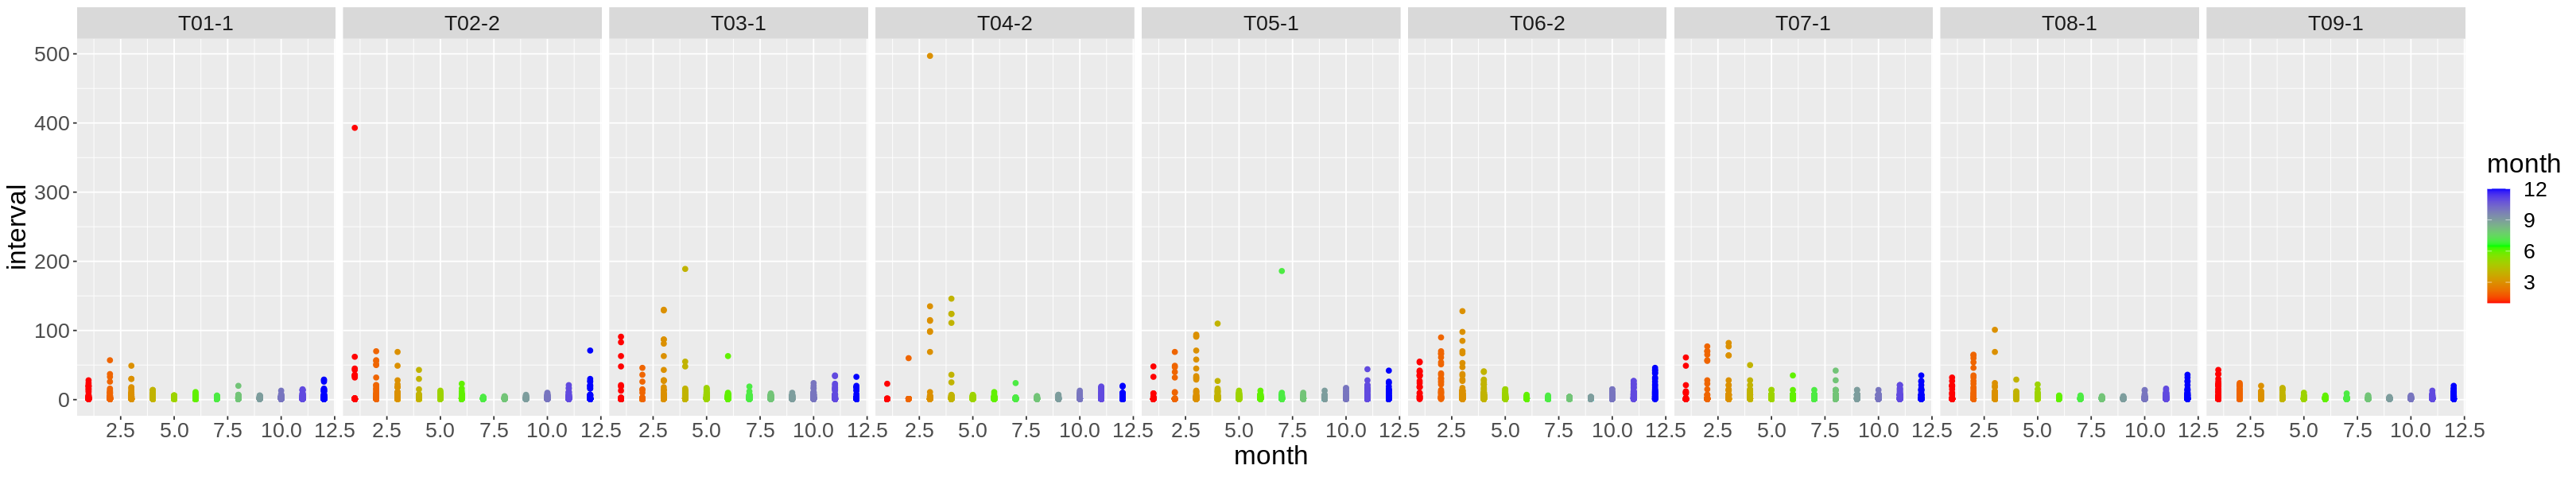

In [21]:
options(repr.plot.width = 27, repr.plot.height = 5)

tbl_safestations %>%
    ggplot2::ggplot(aes(x=month, y=interval, color=month)) + 
    geom_point() +
    scale_color_gradientn(colours = rainbow(3)) +
    facet_grid(col=vars(station), scales="free") +
    theme(text = element_text(size=20))

## Calculate daily rate

In [22]:
tbl_safestations <- tbl_safestations %>%
    mutate(rate = count/interval)

### Plot count, interval, rate
- Most stable stations
  - T02-2, T03-1, T04-2, T05-1, T06-2, T08-1, T09-2
- Essentially T01-1 and T07-1 are **very** responsive to scaling by interval
- Promising that long intervals are often often winter months-which is least likely to affect our results as count are often lower and the summer months give uss the highest numbers of moth abundance

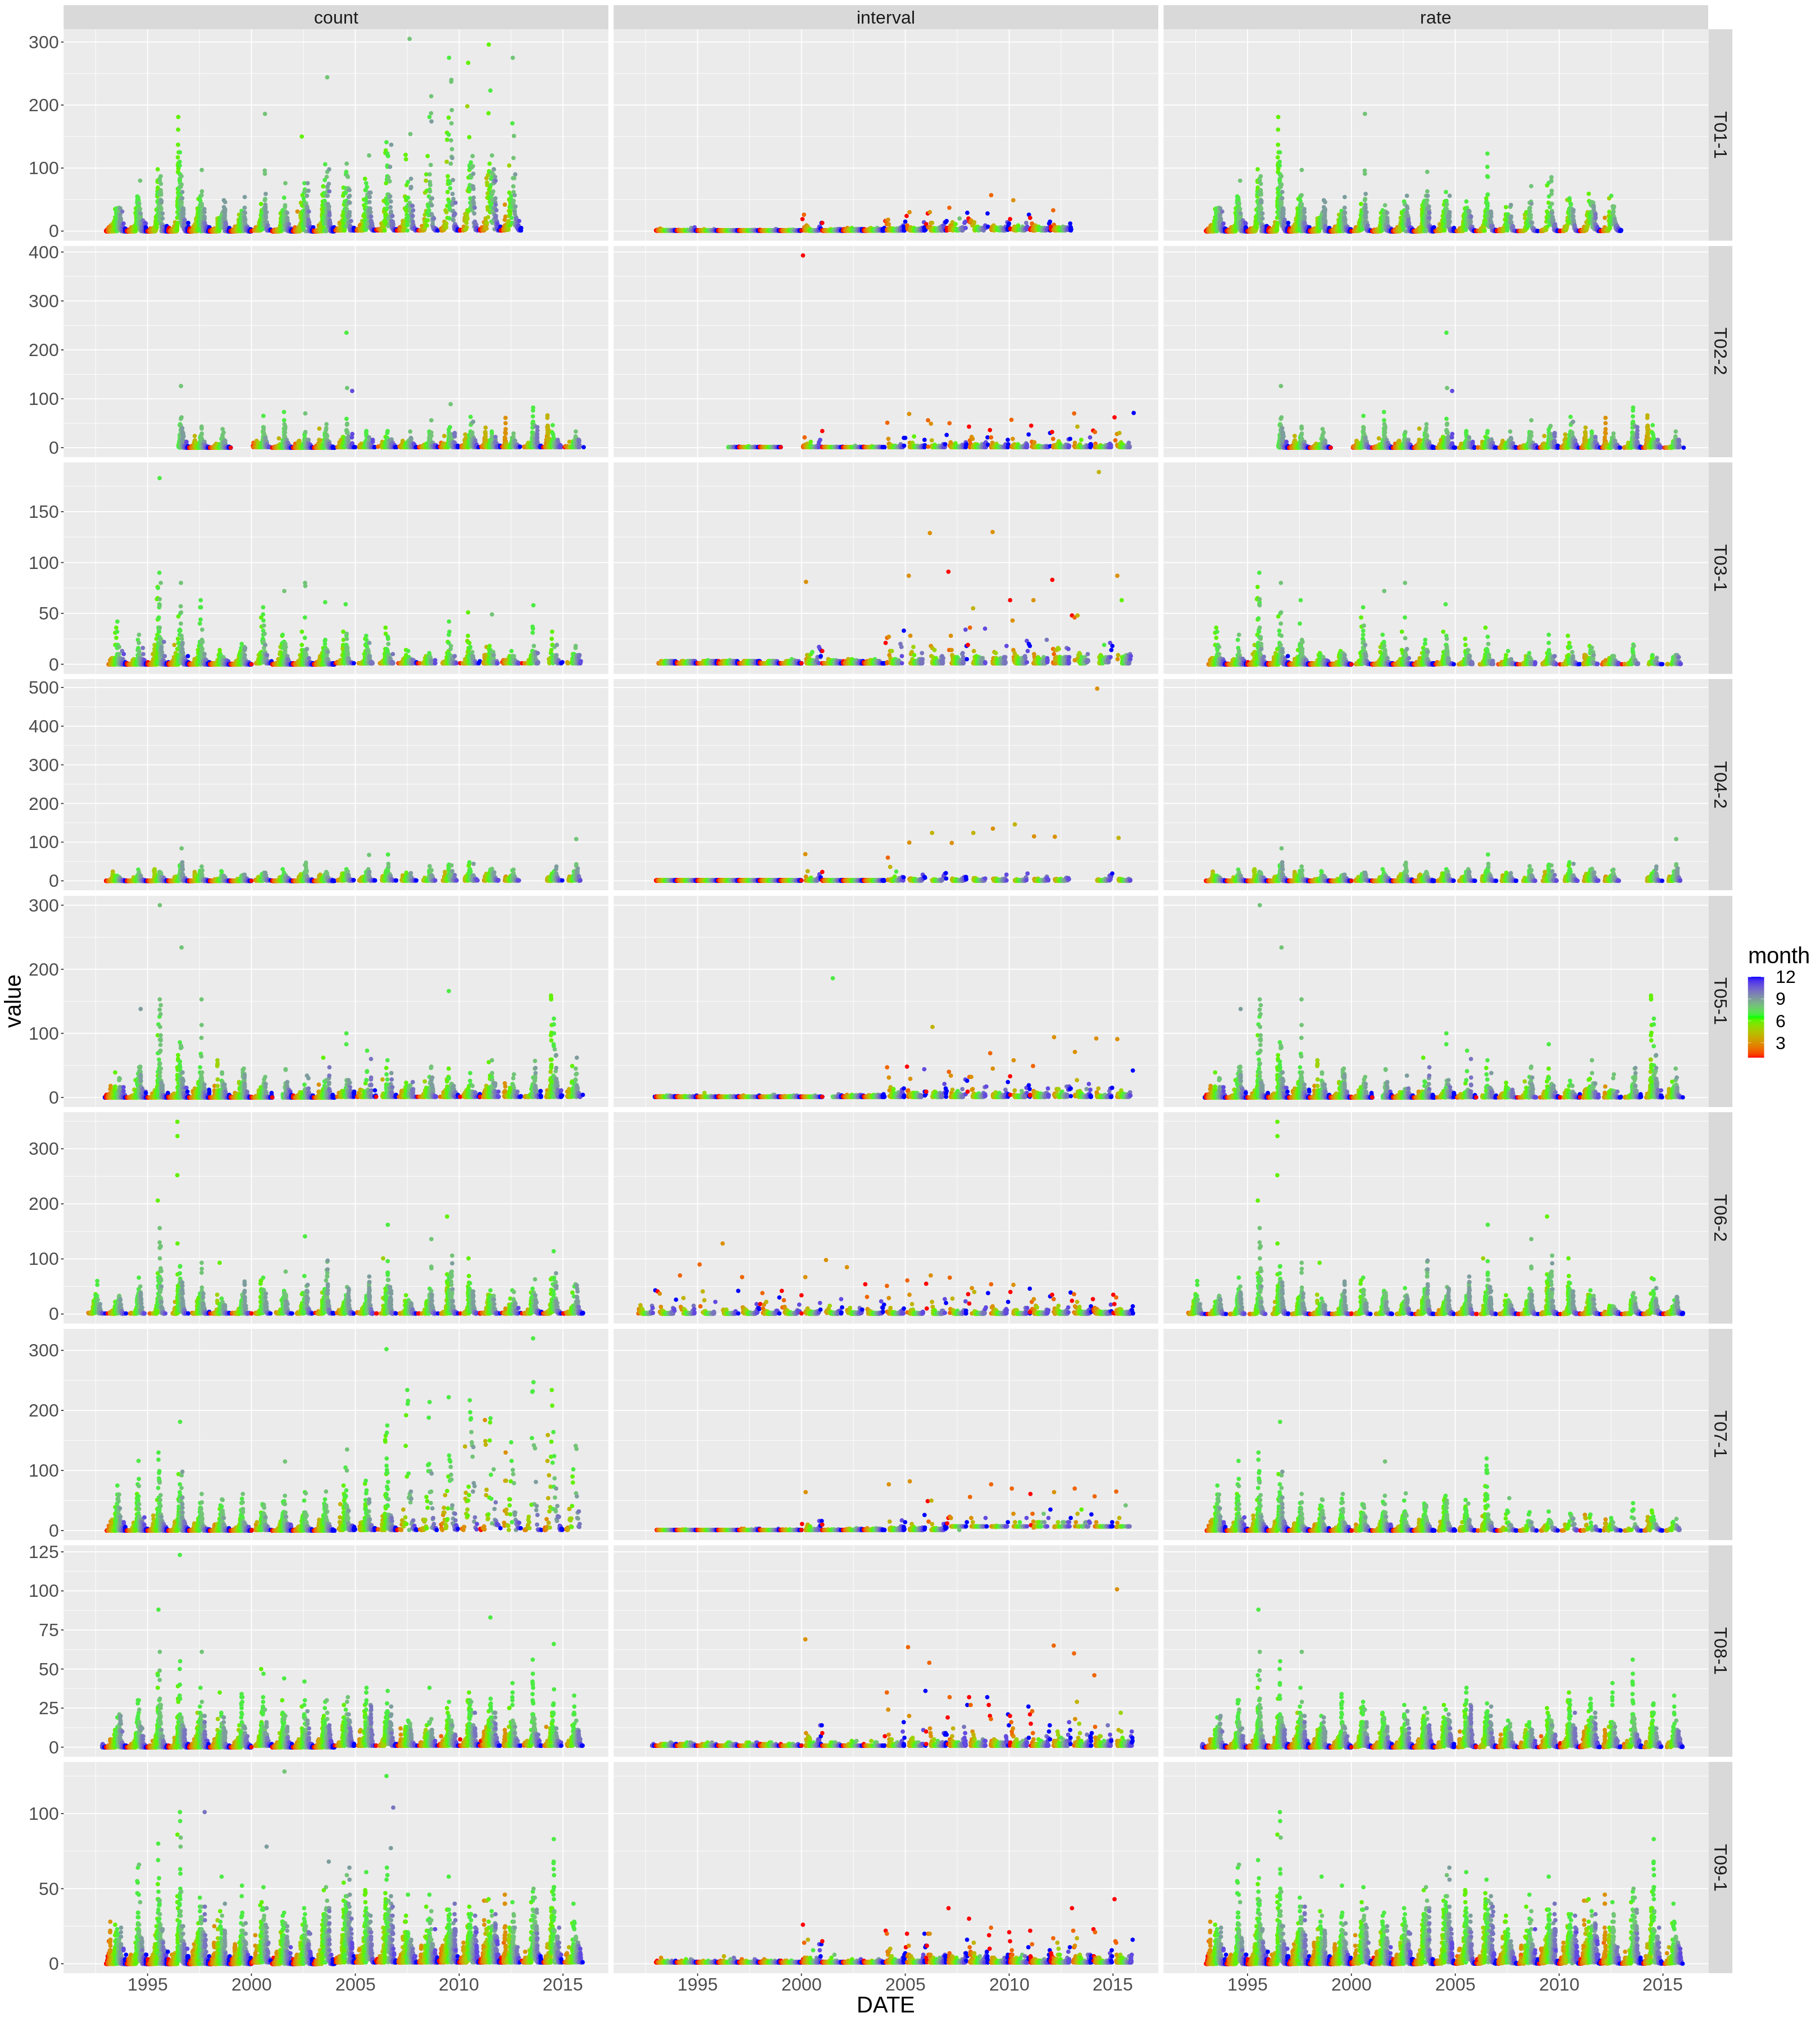

In [23]:
options(repr.plot.width = 27, repr.plot.height = 30)

tbl_safestations %>%
    pivot_longer(
        c(count, rate, interval),
        names_to = "value_type",
        values_to = "value"
    ) %>%
    # plot
    ggplot2::ggplot(aes(x=DATE, y=value, color=month)) + 
    geom_point() +
    scale_color_gradientn(colours = rainbow(3)) +
    facet_grid(row=vars(station), col=vars(value_type), scales="free_y") +
    theme(text = element_text(size=24))

# Stable stations
- Appear to have high rates in 1996,1997,1998 across all 
- Sites to have own high rates

In [24]:
stable_stations <- c("T02-2", "T03-1", "T04-2", "T05-1", "T06-2", "T08-1", "T09-2")

tbl_stable <- tbl_safestations %>%
    filter(station %in% stable_stations)

station DATE       count lag_station lagDATE    interval useful_row month
1 T02-2   1996-06-27 3     T02-2       1996-06-26 1        TRUE       6    
2 T02-2   1996-06-28 4     T02-2       1996-06-27 1        TRUE       6    
3 T02-2   1996-06-29 4     T02-2       1996-06-28 1        TRUE       6    
4 T02-2   1996-06-30 6     T02-2       1996-06-29 1        TRUE       6    
5 T02-2   1996-07-01 4     T02-2       1996-06-30 1        TRUE       7    
6 T02-2   1996-07-02 2     T02-2       1996-07-01 1        TRUE       7    
  rate
1 3   
2 4   
3 4   
4 6   
5 4   
6 2

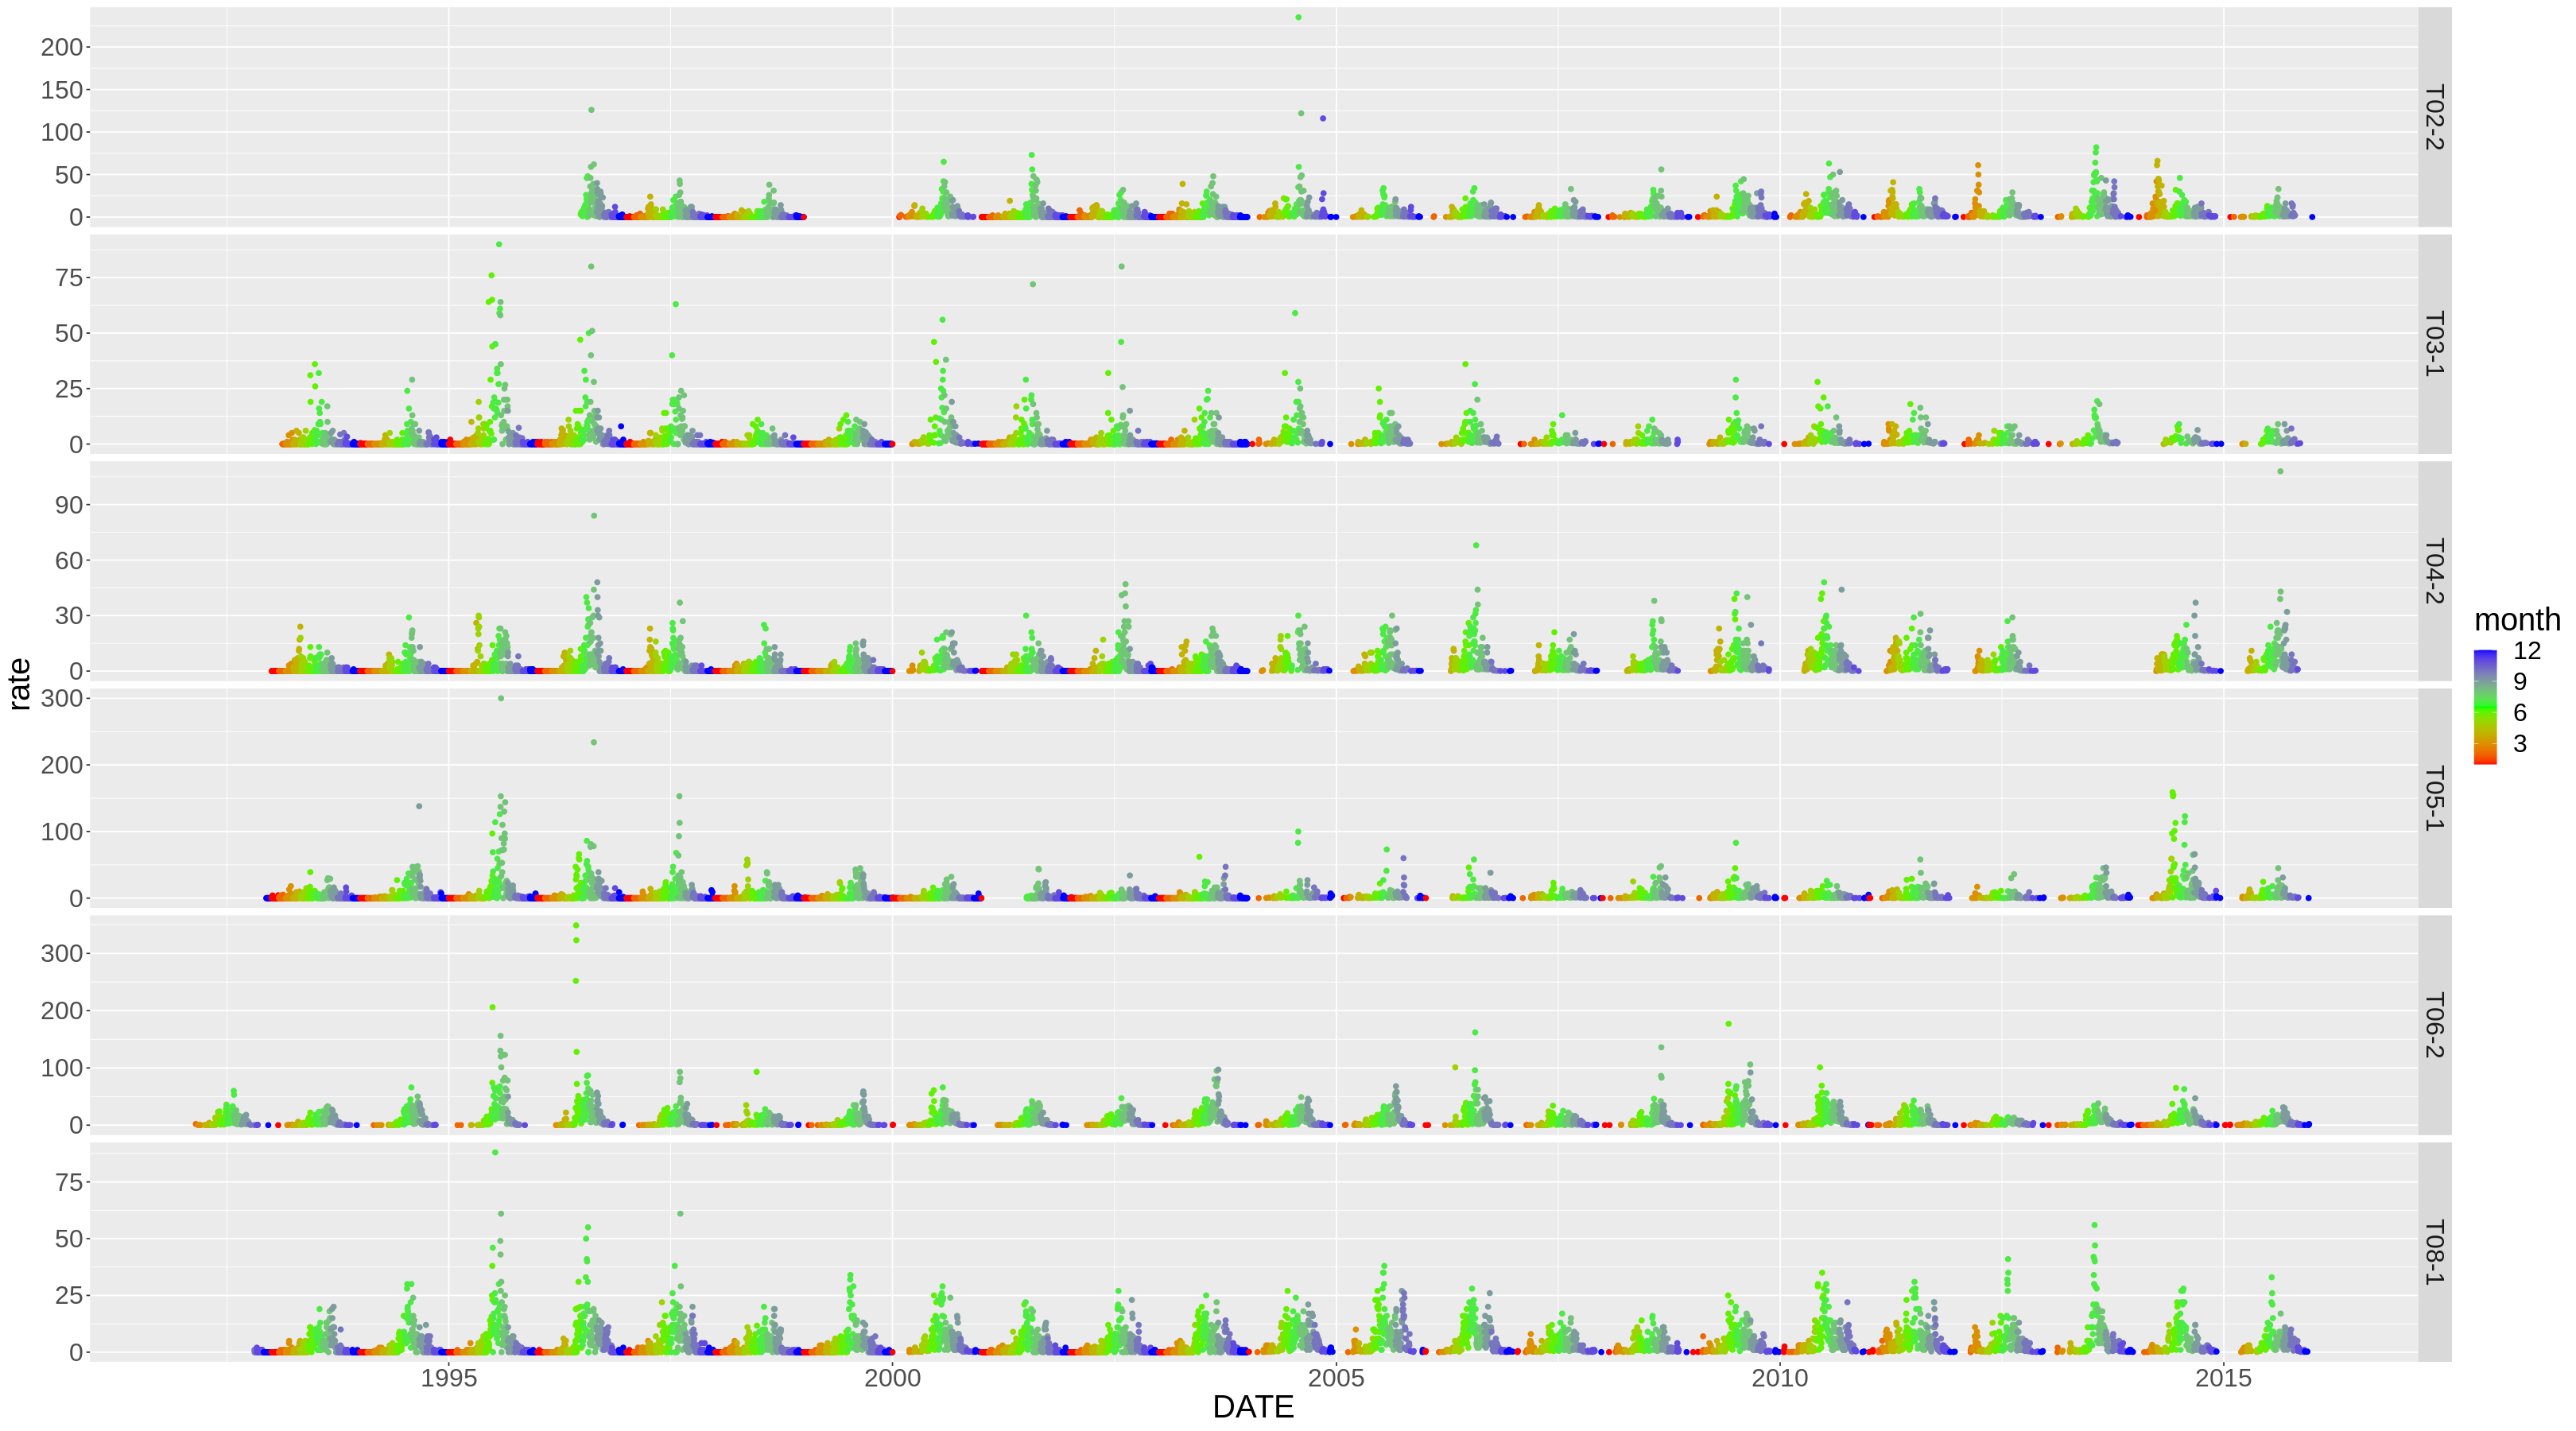

In [25]:
head(tbl_stable)

options(repr.plot.width = 27, repr.plot.height = 15)
tbl_stable %>%
    # plot
    ggplot(aes(x=DATE,y=rate,color=month)) +
    geom_point() +
    scale_color_gradientn(colours = rainbow(3)) +
    facet_grid(row = vars(station), scales='free_y') +
    theme(text = element_text(size=24))

## Concluding remarks
- I think it is best to pursue with only the stable stations
- Discuss with Don: previous suggestion of T08,T09,T06, over other sites. 
  - Does anything observed here support this?
- Pursue analysis with the rate, but ensure some sort of sensitivity analysis is carried out at the end of the analysis
 - This could be somthing as simple as colour-code the observations by interval length to ensure that results do not *correlate* with interval length

## temp, monthly with stable stations

In [26]:
head( tbl_safestations )

station DATE       count lag_station lagDATE    interval useful_row month
1 T01-1   1993-01-03 0     T01-1       1993-01-02 1        TRUE       1    
2 T01-1   1993-01-04 0     T01-1       1993-01-03 1        TRUE       1    
3 T01-1   1993-01-05 0     T01-1       1993-01-04 1        TRUE       1    
4 T01-1   1993-01-06 1     T01-1       1993-01-05 1        TRUE       1    
5 T01-1   1993-01-07 1     T01-1       1993-01-06 1        TRUE       1    
6 T01-1   1993-01-08 0     T01-1       1993-01-07 1        TRUE       1    
  rate
1 0   
2 0   
3 0   
4 1   
5 1   
6 0

In [27]:
tbl_safestations_monthly <- 
    tbl_safestations %>%
        mutate(days_in_month = lubridate::days_in_month(DATE), 
               year=lubridate::year(DATE), 
               monthname = lubridate::month(DATE, label=TRUE, abbr=FALSE) ) %>%
        group_by(station, month, year, days_in_month, monthname) %>%
        summarize(sum_rate = sum(rate)) %>%
        ungroup() %>%
        mutate(
            rate_month = sum_rate/days_in_month,
            date= as.Date(paste(year,monthname,days_in_month,sep='-'), format="%Y-%B-%d")
        ) %>%
        arrange(station,date)

print(tbl_safestations_monthly, n=3)

`summarise()` regrouping output by 'station', 'month', 'year', 'days_in_month' (override with `.groups` argument)



# A tibble: 2,257 x 8
  station month  year days_in_month monthname sum_rate rate_month date      
  <chr>   <dbl> <dbl>         <int> <ord>        <dbl>      <dbl> <date>    
1 T01-1       1  1993            31 January          7      0.226 1993-01-31
2 T01-1       2  1993            28 February        18      0.643 1993-02-28
3 T01-1       3  1993            31 March           64      2.06  1993-03-31
# … with 2,254 more rows


# plot by station monthly rate

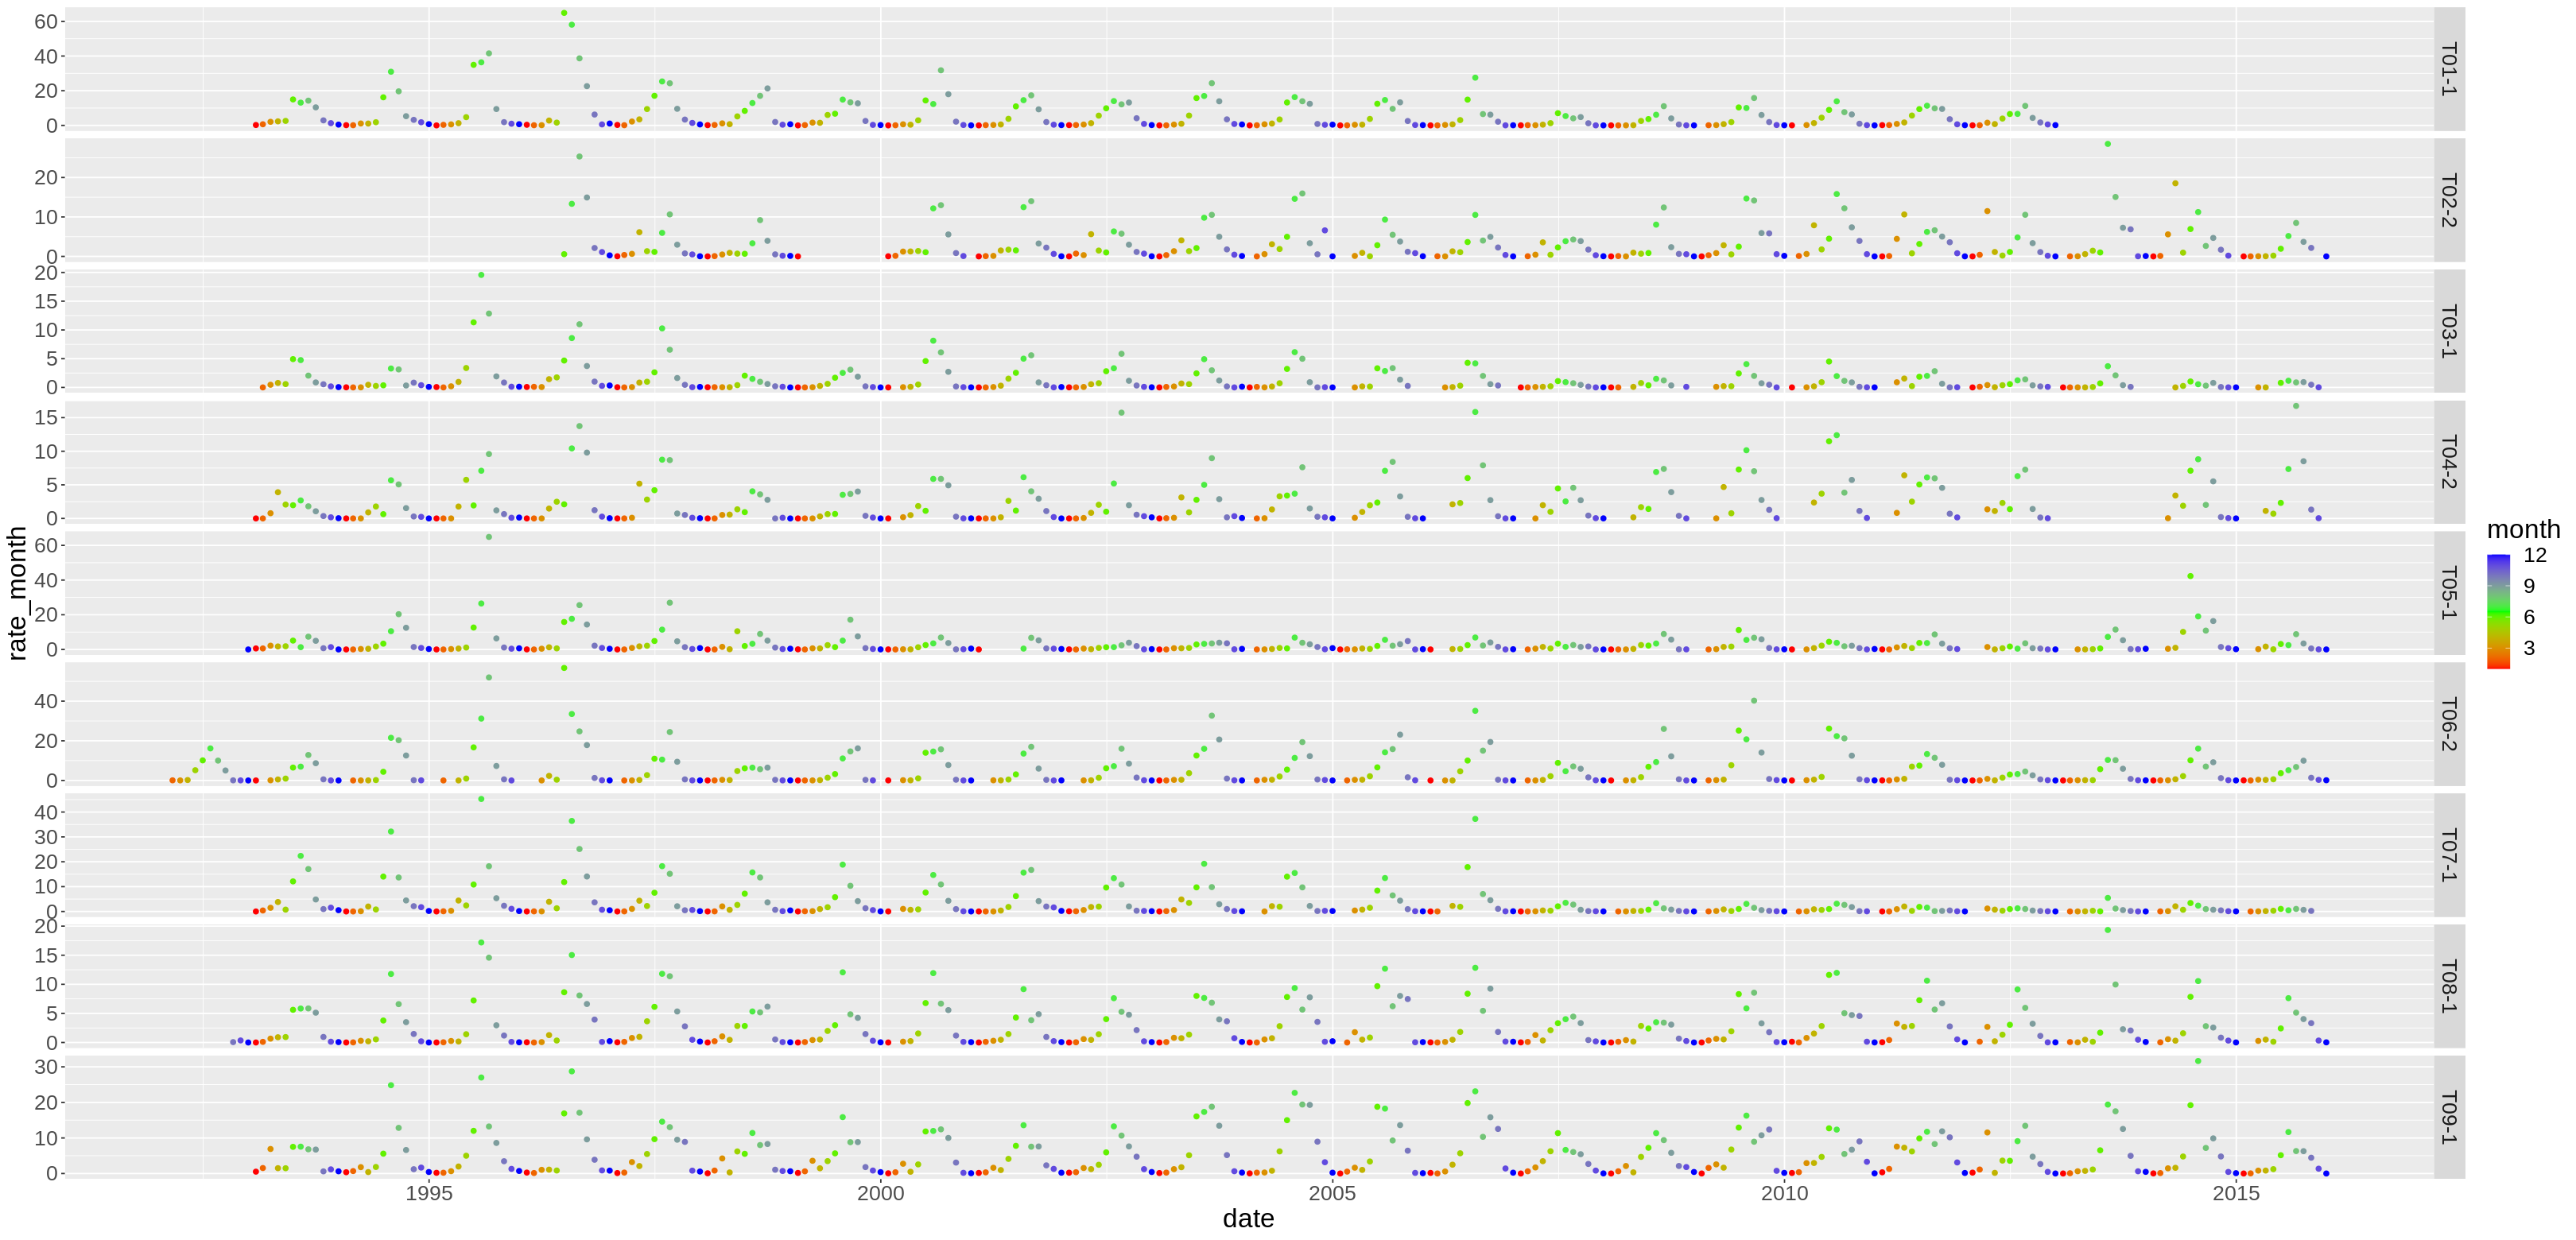

In [28]:
options(repr.plot.width = 27, repr.plot.height = 13)

tbl_safestations_monthly %>%
    ggplot(aes(x=date, y=rate_month, colour=month)) +
    geom_point() +
    scale_color_gradientn(colours = rainbow(3)) +
    facet_grid(rows=vars(station), scales="free_y") +
    theme(text=element_text(size=20))

In [31]:
setwd('/data/notebooks/jupyterlab-workshop/cptMF/')
source_python("cpt/call.py")

cost <- as.list(rep("normal_meanvar"), length(stable_stations))
pen <- as.list(rep("normal_meanvar"), length(stable_stations))
CPT_MF(
    data = tbl_safestations_monthly,
    costname = cost,
    penname = pen,
    use_c = TRUE,
    prep_data = NA,
    return_class = TRUE,
    key_value = "rate_month",
    key_index = "date",
    key = "station"
)

ERROR: Error in py_call_impl(callable, dots$args, dots$keywords): IndexError: list index out of range

Detailed traceback: 
  File "<string>", line 76, in CPT_MF
  File "<string>", line 76, in <listcomp>

